In [ ]:
# 라이브러리 설치

In [ ]:
pip install keras

In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import missingno as msn
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import imblearn
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.inspection import permutation_importance
from keras.layers import Dropout
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# 함수 준비

# 크래머 V 계수 함수
# 크래머 V 계수가 0에 가까우면 두 범주형 변수간 상관관계가 없고, 1에 가까우면 상관관계가 있음
def cramerV(dataframe, varName1, varName2):
    tmpdat = dataframe.copy()
    data = pd.crosstab(tmpdat[varName1], tmpdat[varName2])
    X2 = chi2_contingency(data, correction=False)[0]
    n = np.sum(data).sum()
    minDim = min(data.shape)-1
    V = np.sqrt((X2/n) / minDim)
    return V

# 이산형 변수를 특정 변수 특정 클래스 발생 빈도에 따라 수치화
def discreteVarToPerc(dataframe, dvName, stdClass, idvNames) :
    tmpdat = dataframe.copy()
    
    for idvName in idvNames :
        # 독립변수별 종속변수에 대한 빈도 테이블 계산
        ct = pd.crosstab(tmpdat[dvName], tmpdat[idvName]).apply(lambda r: r/r.sum()).apply(lambda r: r/r.sum()).loc[[stdClass], :]
        
        for ctCol in ct :
            replaceVal = ct[ctCol][stdClass]
            tmpdat[idvName] = tmpdat[idvName].replace(ctCol, replaceVal)
            
    return tmpdat

In [ ]:
#########################################################################################################################################







In [ ]:
# <1. 문제 정의>
# 보험 사기 여부를 판별하는 모델을 작성
# 종속변수가 Fraud, not Fraud로 나오는 이진 분류 문제
# 이를 통계적으로 해석해보고 머신러닝 알고리즘을 이용하여 분류 모델을 생성
# 분류 모델을 작성하는 것만이 아닌 분류된 모델을 설명하는 것 까지를 수행

# - for who : 정상 비정상 분류 문제에 관심이 있는 분들
# - 프로젝트 기대 효과 : 통계적 기법에서 머신러닝까지, 데이터로 결론을 뽑아내는 전체적인 
# 프로세스를 경험을 축적 (교육/학습적 목적)
# - 현 상태 : 실제 데이터를 얻어올수는 없는 상태. 
# 데이터 수집은 Kaggle 에 공개된 데이터를 사용 가능
# Kaggle에 존재하는 분석 방법론이 존재하므로 이를 참고하되, 동일하지 않은 방법으로 
# 분석을 진행하여 성능 상승을 기대함
# 성공 평가 지표 : Kaggle에 존재하는 모델의 성능(Testing 최대 정확도 87%)을 능가하는 
# 모델 생성 및 모델을 설명하는 것까지를 수행

In [ ]:
#########################################################################################################################################







In [ ]:
# <2. 자료 수집>
# 보험 사기 여부를 가려낼 수 있는 데이터가 필요
# https://www.kaggle.com/roshansharma/fraud-detection-in-insurance-claims/data?select=insurance_claims.csv
# 위 캐글 공개 데이터를 사용

In [3]:
# 데이터 불러오기

df = pd.read_csv("/Users/ihyeon-u/Downloads/insurance_claims.csv")

In [ ]:
# (기본 열 제거)
# 확실히 제거할 이유를 가진 열 제거 (Kaggle 원문에서 제거하는 컬럼)

In [4]:
df.shape[1]

39

In [5]:
# 1. policy_number는, 연속형 변수가 아니면서 고유값처럼 희소하기에 삭제
df = df.drop(['policy_number'], axis='columns')
df.shape[1]

38

In [6]:
# 2. policy_bind_date는, 결과인 fraud_reported가 아닌 policy 에 관련된 날짜
df = df.drop(['policy_bind_date'], axis='columns')
df.shape[1]

37

In [7]:
# 3. incident_date, 역시 결과인 fraud_reported가 아닌 incident 에 관련된 날짜입니다.
df = df.drop(['incident_date'], axis='columns')
df.shape[1]

36

In [8]:
# 4. incident_location은, 이를 대신하여 incident_city가 존재하고, 
df = df.drop(['incident_location'], axis='columns')
df.shape[1]

35

In [9]:
# 5. auto_model은 auto_make 와 비슷한 의미인데, 보다 대분류에 속하는 auto_make만 사용
df = df.drop(['auto_make'], axis='columns')
df.shape[1]

34

In [ ]:
#########################################################################################################################################







In [ ]:
# <3. 탐색적 자료 분석 EDA>

In [10]:
print(df.columns)

Index(['months_as_customer', 'age', 'policy_state', 'policy_csl',
       'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_model',
       'auto_year', 'fraud_reported'],
      dtype='object')


In [ ]:
# [탐색적 자료분석을 하기 이전에 먼저 결측값 처리]

In [12]:
df.isnull().sum().sum()

0

In [13]:
df.isnull().sum()

months_as_customer             0
age                            0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_cl

In [ ]:
# NULL 값이 없다고 나오더라도 다른 문자로라도 표시될 가능성이 있음
# 0은 null 값으로 치지 않음
# 각 컬럼별 유니크 값을 확인

In [14]:
for column_name in df:
    print(column_name, " : ", df[column_name].unique(), "\n")

months_as_customer  :  [328 228 134 256 137 165  27 212 235 447  60 121 180 473  70 140 160 196
 460 217 370 413 237   8 257 202 224 241  64 166 155 114 149 147  62 289
 431 199  79 116  37 106 269 265 163 355 175 192 430  91 223 195  22 439
  94  11 151 154 245 119 215 295 254 107 478 128 338 271 222 120 270 319
 194 227 244  78 200 284 275 153  31  41 127  61 207 219  80 325  29 239
 279 350 464 118 298  87 261 453 210 168 390 258 225 164 255 206 203 211
 274  81 280 112  24  93 171 124 287 122 398 214 209  82 193 288 104 101
 375 461 428  45 136 216 278 108  14 276  47  73 294 324  53 426 111  86
 296 125 177 238 449 252 359  19 285  30 342 468 343 404  63 335 142 272
  69  38 281 246 330 362 371 377 172  99 249 190 174  95   2 117 242 440
  20 208 156 232  84 394  35 369 332 243 264  32 259 186 201 436 189 105
  88  40  59  39 123 231 247  48 267 286 253  10 158   1  85 233 266  97
 399 305 129 283  96 176 159 290 299  66 334 429  15 230 250  65 475  77
 229 110 292 451 150 291 162

In [ ]:
# ? 라는 값이 collision_type, property_damage, police_report_available 에서 발견됨
# 그외에는 특이한 값은 없어보임
# ?를 결측값으로 처리

In [15]:
df = df.replace("?", np.NaN)

df.isnull().sum()

months_as_customer               0
age                              0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_zip                      0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_state                   0
incident_city                    0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim        

In [16]:
df.isnull().sum().sum()

881

<AxesSubplot:>

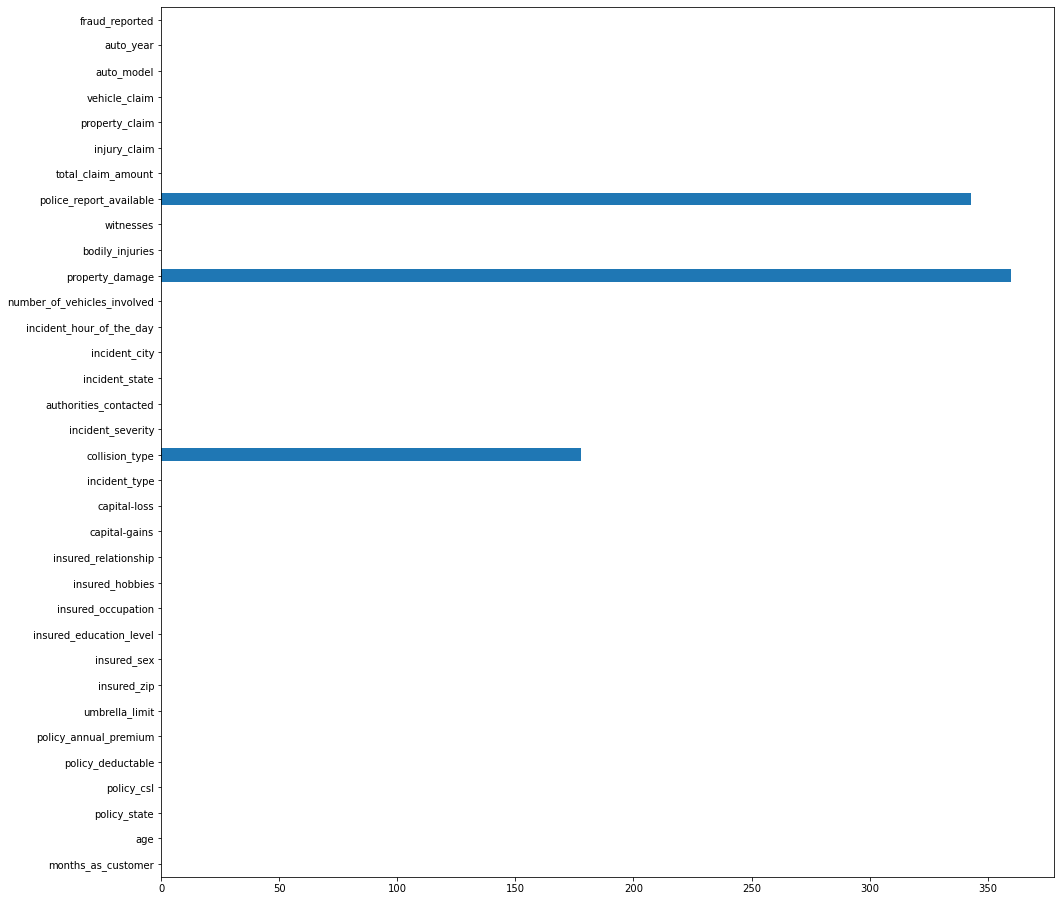

In [17]:
plt.figure(figsize=(16, 16))

# 컬럼별 null 데이터 시각화
df.isnull().sum().plot.barh()

<AxesSubplot:>

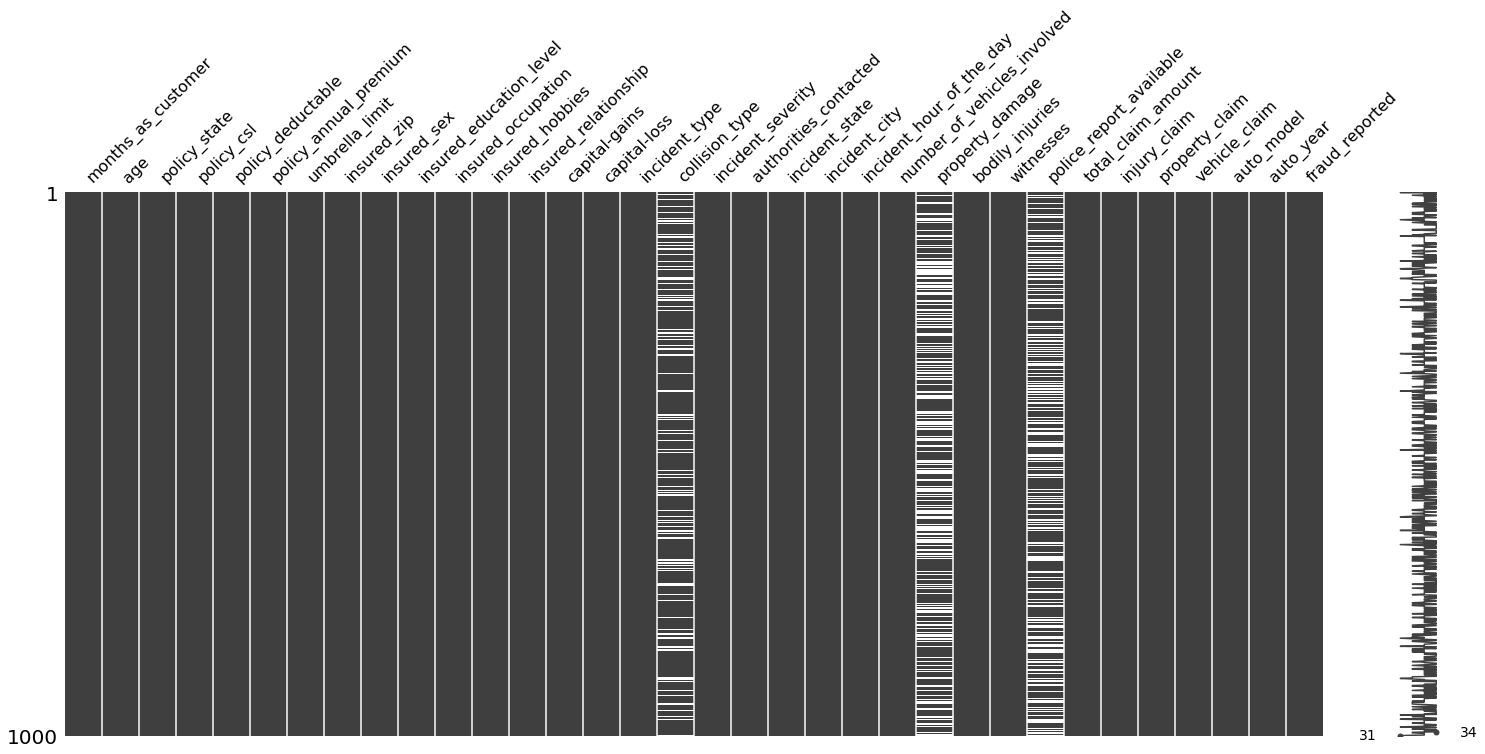

In [18]:
msn.matrix(df)

In [ ]:
# ? 값이 NaN으로 처리되며 위와 같이 변경
# EDA를 하기 전 Null 처리를 먼저 함
# Null 처리도 데이터 전처리 영역이지만 먼저 수행
# df에 결측치를 실행해서 nnDf 할당

# [결측치 처리]
# 아래 나열한 방식들 중 하나를 선택

# 결측치 처리 방법 : 
# 1) 결측된 행을 제거
# 2) 결측된 열을 제거
# 3) 결측된 값을 대체

# >>

In [50]:
# 결측치 처리용 데이터 준비(원본 보존)
nnDf = df.copy()
nnDf

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,466132,MALE,MD,...,1,2,YES,71610,6510,13020,52080,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,...,0,0,NaN,5070,780,780,3510,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,...,2,3,NO,34650,7700,3850,23100,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,...,1,2,NO,63400,6340,6340,50720,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,...,0,1,NO,6500,1300,650,4550,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,...,0,1,NaN,87200,17440,8720,61040,Accord,2006,N
996,285,41,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,...,2,3,NaN,108480,18080,18080,72320,Passat,2015,N
997,130,34,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,...,2,3,YES,67500,7500,7500,52500,Impreza,1996,N
998,458,62,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,...,0,1,YES,46980,5220,5220,36540,A5,1998,N


In [20]:
# 1) 결측된 행을 제거
# 결측 행을 모두 제거 했을 때
deletedRowLen = len(df) - len(df.dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df.dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 660, deletedRowRatio = 66.0%, remainRowLen = 340


In [21]:
# 결측치가 발생하는 열 별 행에 대한 결측치 비율
# 행을 제거한다고 하면 해당 비율만큼의 데이터가 소멸하는 것입니다

# collision_type의 결측 행을 제거 했을 때
deletedRowLen = len(df) - len(df['collision_type'].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df['collision_type'].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 178, deletedRowRatio = 17.8%, remainRowLen = 822


In [22]:
# property_damage의 결측 행을 제거 했을 때
deletedRowLen = len(df) - len(df['property_damage'].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df['property_damage'].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 360, deletedRowRatio = 36.0%, remainRowLen = 640


In [23]:
# property_damage의 결측 행을 제거 했을 때
deletedRowLen = len(df) - len(df['police_report_available'].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df['police_report_available'].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 343, deletedRowRatio = 34.300000000000004%, remainRowLen = 657


In [24]:
# 조합에 따라서
# property_damage - police_report_available
deletedRowLen = len(df) - len(df[['property_damage', 'police_report_available']].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df[['property_damage', 'police_report_available']].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 579, deletedRowRatio = 57.9%, remainRowLen = 421


In [25]:
# property_damage - collision_type
deletedRowLen = len(df) - len(df[['property_damage', 'collision_type']].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df[['property_damage', 'collision_type']].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 475, deletedRowRatio = 47.5%, remainRowLen = 525


In [26]:
# police_report_available - collision_type
deletedRowLen = len(df) - len(df[['police_report_available', 'collision_type']].dropna(axis=0)) # 제거되는 행 개수
remainRowLen = len(df[['police_report_available', 'collision_type']].dropna(axis=0)) # 남은 행 개수
deletedRowRatio = (deletedRowLen / len(df)) # 제거되는 데이터 행 비율

print("deletedRowLen = {0}, deletedRowRatio = {1}%, remainRowLen = {2}".format(deletedRowLen, deletedRowRatio*100, remainRowLen))

deletedRowLen = 465, deletedRowRatio = 46.5%, remainRowLen = 535


In [ ]:
# 즉, 열을 모두 포함한 상태로 행을 날리면 66%의 손실이 나는 것이고, 
# 2개 씩 각 조합별로 행을 날리면 46% 이상, 66% 이하의 손실,
# 하나의 열만 남긴 상태로 행을 날리면 17.8% 이상, 36% 이하의 손실이 나는 것...
# 만약 위 방식대로 행을 모두 삭제하더라도 데이터가 충분히 많다면 이를 수행해도 됨
# 하지만 데이터 제거 비율이 너무 높거나 삭제 후 데이터 개수가 너무 적다면 X

In [ ]:
# 처리할 것이라면 아래와 같이





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [27]:
# 1. 전체 행 제거
nnDf = nnDf.dropna(axis=0)
print("null : {0}, total len : {1}".format(nnDf.isnull().sum().sum(), len(nnDf)))

null : 0, total len : 340


In [28]:
# 2. 특정 행 제거
# property_damage 행 제거
nnDf = nnDf.dropna(axis=0, subset=["property_damage"])

print("null : {0}, total len : {1}".format(nnDf["property_damage"].isnull().sum(), len(nnDf)))

null : 0, total len : 340


In [29]:
# police_report_available 행 제거
nnDf = nnDf.dropna(axis=0, subset=["police_report_available"])

print("null : {0}, total len : {1}".format(nnDf["police_report_available"].isnull().sum(), len(nnDf)))

null : 0, total len : 340


In [30]:
# collision_type 행 제거
nnDf = nnDf.dropna(axis=0, subset=["collision_type"])

print("null : {0}, total len : {1}".format(nnDf["collision_type"].isnull().sum(), len(nnDf)))

null : 0, total len : 340


In [ ]:





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 1 끝 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!






In [42]:
# 2) 결측된 열을 제거
nnDf.shape[1] # 전체 열 개수

34

In [43]:
nnDf.shape[1] - nnDf.dropna(axis=1).shape[1] # 결측치가 있는 열 개수

3

In [ ]:
# 총 컬럼 39개 중, 독립변수는 38개, 그중 결측값이 존재하는 컬럼은 3개...
# 다행히 종속변수에 결측치는 없는 상황

# 결측치 포함 독립변수가 종속변수에 미치는 영향이 작다면 이를 제거하는 것이 좋다고 생각

# 결측치가 집중적으로 많이 발생하는 열이라는 것은,
# 관측시 결측이 일어날 가능성이 있다는 것으로 생각할 수 있고,

# 분석 모델을 만들 때 지나치게 복잡하고 변수가 많은 모델도 좋지 않기에
# 차원 축소의 의미로 생각 할 수 있음.

# 그렇지만, 이것이 결과에 끼치는 영향이 크다면 모델 성능을 낮추게 됨...
# 단독으로 결과에 끼치는 영향뿐 아니라 다른 독립변수들과의 조합으로 결과에 끼치는 영향도 있기에 주의

# 일단 각 열이 결과에 미치는 영향을 분석
# 해당 열이 결과에 끼치는 영향이 매우 크다면
# 그 열을 유지해야 하고, 해당 열이 결과에 끼치는 영향이 작다면 제거하도록 결정

# 결측값이 탐지된 독립변수 3개는 모두 범주형 데이터
# 범주형 독립변수가 범주형 종속변수에 미치는 영향을 알아보려면,
# Cramer`s V 를 사용

In [44]:
cramerV(nnDf, 'property_damage', 'fraud_reported')

0.07532898745287961

In [45]:
cramerV(nnDf, 'police_report_available', 'fraud_reported')

0.025046388004164966

In [46]:
cramerV(nnDf, 'collision_type', 'fraud_reported')

0.05423318271168127

In [ ]:
# 단순히 두 범주형 변수끼리는 상관관계가 없다고 나옵니다.
# 모자이크 플롯을 이용해 이를 확인해보면,

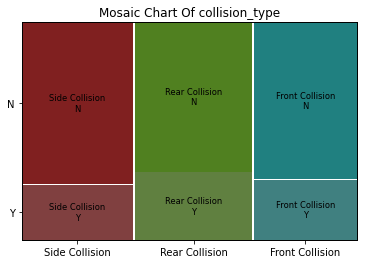

'cramer`s V : 0.054'

In [47]:
# colName 을 원하는 범주형 변수 컬럼명으로 바꿔서 확인

colName = 'collision_type'

mosaic(nnDf, [colName, 'fraud_reported'], 

      title='Mosaic Chart Of '+colName)

plt.show()
f"cramer`s V : {cramerV(nnDf, colName, 'fraud_reported'):.3f}"

In [ ]:
# 모자이크 플롯은 각 클래스별로 종속변수에 대한 비율이 크게 차이가 나면 해당 변수가 유효하다고 판단 가능합니다.

# 처리할 것이라면 아래와 같이





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 2 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [48]:
# 원하는 컬럼을 제거
nnDf = nnDf.drop(['police_report_available', 'collision_type', 'property_damage'], axis='columns')
print("null : {0}, total col : {1}".format(nnDf.isnull().sum().sum(), nnDf.shape[1]))

null : 0, total col : 31


In [49]:
nnDf.shape

(1000, 31)

In [ ]:





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 2 끝 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!






In [ ]:
# 3) 결측된 값을 대체
# 방법
# 1. 중앙값 : 연속형 데이터는 중앙값, 범주형 데이터는 최빈값을 사용





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 3 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [51]:
nnDf = nnDf.fillna({'property_damage':df['property_damage'].mode()[0],
           'police_report_available':df['police_report_available'].mode()[0], 
           'collision_type':df['collision_type'].mode()[0]})

In [52]:
nnDf['property_damage']
nnDf['property_damage'].isnull().sum()

0

In [53]:
nnDf['police_report_available']
nnDf['police_report_available'].isnull().sum()

0

In [54]:
nnDf['collision_type']
nnDf['collision_type'].isnull().sum()

0

In [55]:
nnDf.isnull().sum().sum()

0

In [56]:
nnDf.shape

(1000, 34)

In [ ]:





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 데이터 결측치 처리 3 끝 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!






In [ ]:
# 2. 기본값 설정
# 기본값 설정은 해당 변수에 대한 합당한 근거가 필요하기에 여기서는 보류
# 단, Kaggle 링크 원작자의 처리론,

# collision_type 를 최빈값으로 사용했고, 
# 그 외에는 모두 "NO" 로 처리

# 결과적으로 최빈값을 사용한 것과 동일

In [ ]:
# 3. 통계적 예측
# 현재 주어진 데이터들을 기반으로 종속변수를 결측치가 존재하는 행으로 두고 분류 예측 실행

# ex ) SVM을 이용하여 비어있는 값이 있는 컬럼의 값을 예측하는 모델을 만들고, 예측을 통해 그 값을 사용

# TODO

In [ ]:
# [EDA 수행]
# 위에서 결측값을 제거했으니 데이터로 EDA를 수행

In [57]:
nnDf.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,466132,MALE,MD,...,1,2,YES,71610,6510,13020,52080,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,...,0,0,NO,5070,780,780,3510,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,...,2,3,NO,34650,7700,3850,23100,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,...,1,2,NO,63400,6340,6340,50720,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,...,0,1,NO,6500,1300,650,4550,RSX,2009,N


In [58]:
nnDf.tail()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year,fraud_reported
995,3,38,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,...,0,1,NO,87200,17440,8720,61040,Accord,2006,N
996,285,41,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,...,2,3,NO,108480,18080,18080,72320,Passat,2015,N
997,130,34,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,...,2,3,YES,67500,7500,7500,52500,Impreza,1996,N
998,458,62,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,...,0,1,YES,46980,5220,5220,36540,A5,1998,N
999,456,60,OH,250/500,1000,766.19,0,612260,FEMALE,Associate,...,0,3,NO,5060,460,920,3680,E400,2007,N


In [59]:
nnDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_csl                   1000 non-null   object 
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_zip                  1000 non-null   int64  
 8   insured_sex                  1000 non-null   object 
 9   insured_education_level      1000 non-null   object 
 10  insured_occupation           1000 non-null   object 
 11  insured_hobbies              1000 non-null   object 
 12  insured_relationship         1000 non-null   object 
 13  capital-gains      

In [60]:
nnDf.shape

(1000, 34)

In [61]:
# 기초 통계량 확인
nnDf.describe()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [62]:
nnDf.describe(include='all')

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year,fraud_reported
count,1000.000000,1000.000000,1000,1000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000,1000,...,1000.000000,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000
unique,NaN,NaN,3,3,NaN,NaN,NaN,NaN,2,7,...,NaN,NaN,2,NaN,NaN,NaN,NaN,39,NaN,2
top,NaN,NaN,OH,250/500,NaN,NaN,NaN,NaN,FEMALE,JD,...,NaN,NaN,NO,NaN,NaN,NaN,NaN,RAM,NaN,N
freq,NaN,NaN,352,351,NaN,NaN,NaN,NaN,537,161,...,NaN,NaN,686,NaN,NaN,NaN,NaN,43,NaN,753
mean,203.954000,38.948000,NaN,NaN,1136.000000,1256.406150,1.101000e+06,501214.488000,NaN,NaN,...,0.992000,1.487000,NaN,52761.94000,7433.420000,7399.570000,37928.950000,NaN,2005.103000,NaN
std,115.113174,9.140287,NaN,NaN,611.864673,244.167395,2.297407e+06,71701.610941,NaN,NaN,...,0.820127,1.111335,NaN,26401.53319,4880.951853,4824.726179,18886.252893,NaN,6.015861,NaN
min,0.000000,19.000000,NaN,NaN,500.000000,433.330000,-1.000000e+06,430104.000000,NaN,NaN,...,0.000000,0.000000,NaN,100.00000,0.000000,0.000000,70.000000,NaN,1995.000000,NaN
25%,115.750000,32.000000,NaN,NaN,500.000000,1089.607500,0.000000e+00,448404.500000,NaN,NaN,...,0.000000,1.000000,NaN,41812.50000,4295.000000,4445.000000,30292.500000,NaN,2000.000000,NaN
50%,199.500000,38.000000,NaN,NaN,1000.000000,1257.200000,0.000000e+00,466445.500000,NaN,NaN,...,1.000000,1.000000,NaN,58055.00000,6775.000000,6750.000000,42100.000000,NaN,2005.000000,NaN
75%,276.250000,44.000000,NaN,NaN,2000.000000,1415.695000,0.000000e+00,603251.000000,NaN,NaN,...,2.000000,2.000000,NaN,70592.50000,11305.000000,10885.000000,50822.500000,NaN,2010.000000,NaN


([<matplotlib.patches.Wedge at 0x7fb5aee85278>,
 [Text(-0.7851136132870644, 0.7704522141128092, 'N'),
  Text(0.785113649354535, -0.7704521773589873, 'Y')],
 [Text(-0.42824378906567145, 0.4202466622433504, '75.30%\n(753)'),
  Text(0.4282438087388372, -0.42024664219581126, '24.70%\n(247)')])

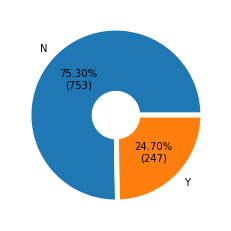

In [63]:
# 정답 레이블(fraud_reported) 데이터 불균형 확인

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(nnDf['fraud_reported'].value_counts(),autopct=make_autopct(nnDf['fraud_reported'].value_counts()), 
        labels=nnDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [64]:
nnDf['fraud_reported'].value_counts()
# not Fraud가 75.3%, Fraud가 24.7%로,
# 이상적인 5:5 데이터는 아니지만 심각한 수준의 불균형은 아니라고 판단

N    753
Y    247
Name: fraud_reported, dtype: int64

In [65]:
# 연속형 변수 상관계수
nnDf.corr()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
months_as_customer,1.000000,0.922098,0.026807,0.005018,0.015498,0.017895,0.006399,0.020209,0.070639,0.014736,-0.010162,0.058383,0.062108,0.065329,0.034940,0.061013,-0.000292
age,0.922098,1.000000,0.029188,0.014404,0.018126,0.025604,-0.007075,0.007368,0.087161,0.022102,-0.015679,0.052359,0.069863,0.075522,0.060898,0.062588,0.001354
policy_deductable,0.026807,0.029188,1.000000,-0.003245,0.010870,0.004545,0.035212,-0.023544,0.060935,0.051214,-0.022765,0.066639,0.022839,0.039107,0.064792,0.005269,0.026105
policy_annual_premium,0.005018,0.014404,-0.003245,1.000000,-0.006247,0.032354,-0.013738,0.023547,-0.001578,-0.045991,0.026780,0.002332,0.009094,-0.017633,-0.011654,0.020246,-0.049226
umbrella_limit,0.015498,0.018126,0.010870,-0.006247,1.000000,0.019671,-0.047268,-0.024056,-0.023257,-0.021270,0.022743,-0.006738,-0.040344,-0.045412,-0.023790,-0.038584,0.009893
insured_zip,0.017895,0.025604,0.004545,0.032354,0.019671,1.000000,0.006303,0.049372,0.008274,0.027448,0.028695,0.019805,-0.033873,-0.017495,-0.006841,-0.041083,-0.032736
capital-gains,0.006399,-0.007075,0.035212,-0.013738,-0.047268,0.006303,1.000000,-0.046904,-0.016406,0.061643,0.055829,-0.017651,0.015980,0.025934,-0.000779,0.015836,0.031398
capital-loss,0.020209,0.007368,-0.023544,0.023547,-0.024056,0.049372,-0.046904,1.000000,-0.025054,-0.014895,-0.024418,-0.041330,-0.036060,-0.046060,-0.022863,-0.032665,-0.056615
incident_hour_of_the_day,0.070639,0.087161,0.060935,-0.001578,-0.023257,0.008274,-0.016406,-0.025054,1.000000,0.120794,-0.034563,0.006527,0.217702,0.165768,0.179536,0.215626,0.021368
number_of_vehicles_involved,0.014736,0.022102,0.051214,-0.045991,-0.021270,0.027448,0.061643,-0.014895,0.120794,1.000000,0.014030,-0.014669,0.274278,0.224650,0.219084,0.269393,0.034554


In [66]:
# 연속형 변수 공분산
nnDf.cov()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
months_as_customer,1.325104e+04,970.201810,1.888144e+03,1.410315e+02,4.098745e+06,1.476998e+05,2.053193e+04,6.537987e+04,56.525149,1.728322,-0.959327,7.468871,1.887564e+05,3.670575e+04,1.940521e+04,1.326454e+05,-0.202464
age,9.702018e+02,83.544841,1.632352e+02,3.214568e+01,3.806326e+05,1.678029e+04,-1.802445e+03,1.892620e+03,5.538026,0.205834,-0.117534,0.531856,1.685908e+04,3.369297e+03,2.685543e+03,1.080424e+04,0.074430
policy_deductable,1.888144e+03,163.235235,3.743784e+05,-4.848613e+02,1.527928e+07,1.993895e+05,6.005009e+05,-4.048617e+05,259.175175,31.927928,-11.423423,45.313313,3.689501e+05,1.167917e+05,1.912697e+05,6.088869e+04,96.088088
policy_annual_premium,1.410315e+02,32.145675,-4.848613e+02,5.961772e+04,-3.504155e+06,5.664307e+05,-9.349637e+04,1.615803e+05,-2.678940,-11.441581,5.362622,0.632688,5.862176e+04,-2.101409e+04,-1.372875e+04,9.336460e+04,-72.306760
umbrella_limit,4.098745e+06,380632.632633,1.527928e+07,-3.504155e+06,5.278077e+12,3.240420e+09,-3.026763e+09,-1.553189e+09,-371415.415415,-49788.788789,42850.850851,-17204.204204,-2.447073e+09,-5.092246e+08,-2.637003e+08,-1.674148e+09,136733.733734
insured_zip,1.476998e+05,16780.292669,1.993895e+05,5.664307e+05,3.240420e+09,5.141121e+09,1.259612e+07,9.948976e+07,4124.025754,2005.227796,1687.420324,1578.175520,-6.412337e+07,-6.122698e+06,-2.366451e+06,-5.563422e+07,-14120.443708
capital-gains,2.053193e+04,-1802.445245,6.005009e+05,-9.349637e+04,-3.026763e+09,1.259612e+07,7.768588e+08,-3.674132e+07,-3178.586987,1750.552653,1276.184985,-546.757457,1.175952e+07,3.528093e+06,-1.047625e+05,8.336193e+06,5264.676376
capital-loss,6.537987e+04,1892.620220,-4.048617e+05,1.615803e+05,-1.553189e+09,9.948976e+07,-3.674132e+07,7.898403e+08,-4894.551752,-426.512212,-562.812412,-1290.858959,-2.675643e+07,-6.318256e+06,-3.100158e+06,-1.733802e+07,-9571.920821
incident_hour_of_the_day,5.652515e+01,5.538026,2.591752e+02,-2.678940e+00,-3.714154e+05,4.124026e+03,-3.178587e+03,-4.894552e+03,48.321586,0.855540,-0.197045,0.050422,3.995424e+04,5.624392e+03,6.021358e+03,2.830849e+04,0.893562
number_of_vehicles_involved,1.728322e+00,0.205834,3.192793e+01,-1.144158e+01,-4.978879e+04,2.005228e+03,1.750553e+03,-4.265122e+02,0.855540,1.038117,0.011724,-0.016610,7.378070e+03,1.117208e+03,1.076978e+03,5.183885e+03,0.211795


<AxesSubplot:>

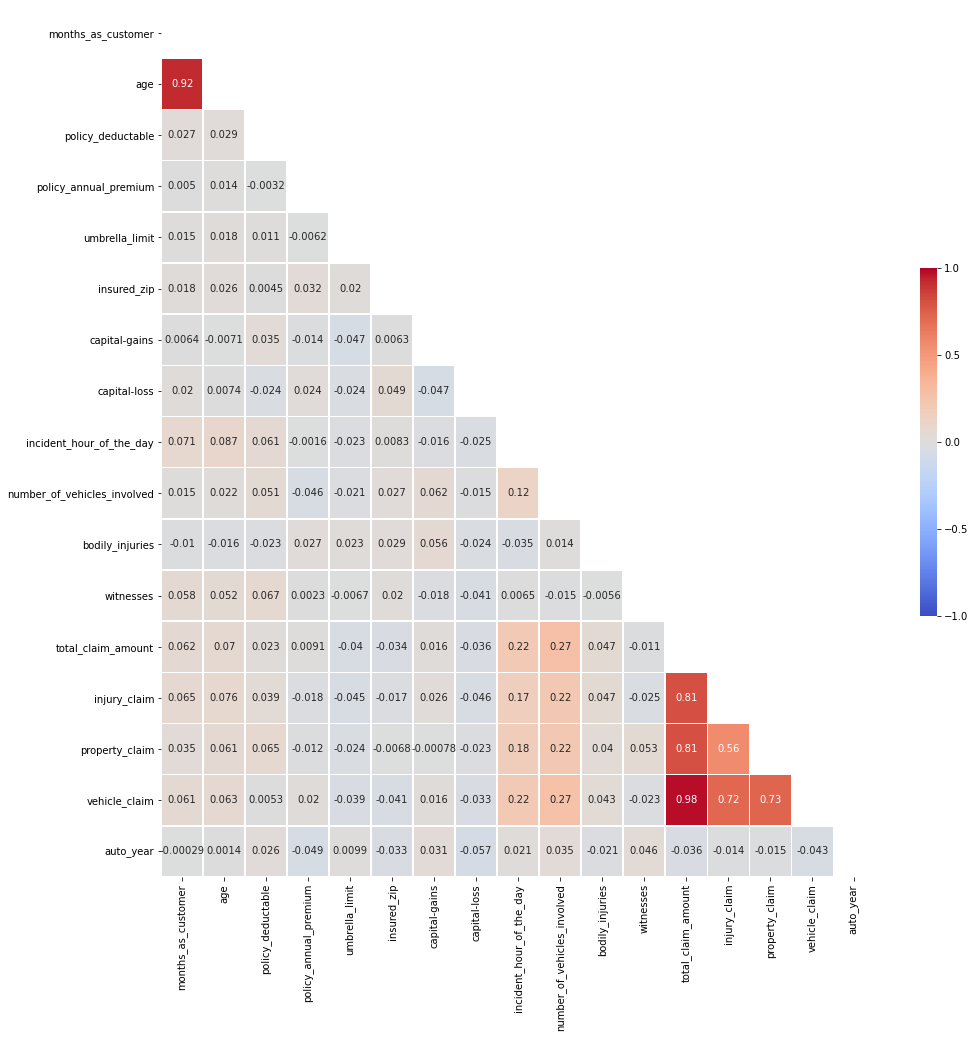

In [67]:
plt.figure(figsize=(16, 16))

corr_matrix = nnDf.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
sb.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
           mask = mask,
           cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},
           vmin = -1,
           vmax = 1,
            cmap='coolwarm',
            annot=True,
            linewidth=0.5)

In [ ]:
# 위 상관계수 히트맵은, 상관계수가 양수 1에 가까우면 붉은색, 음수 1에 가까우면 파란색으로 나타납니다.
# 상관관계의 기준을 0.2로 두었을 때 서로 상관관계가 있는 것으론,
# number_of_vehicles_involved - (total_claim_amount, injury_claim, property_claim, vehicle_claim)
# incident_hour_of_the_day - (total_claim_amount, injury_claim, property_claim, vehicle_claim)
# age - months_as_customer
# total_claim_amount - (injury_claim, property_claim, vehicle_claim)
# injury_claim - (property_claim, vehicle_claim)
# property_claim - (vehicle_claim)
# 위와 같습니다.
# 이에 대한 처리는 데이터를 살펴보고 전처리 단계에서 처리합니다.

# 밑으로는 각 데이터를 살펴봅니다.
# 연속형 변수라면 분포 곡선과 박스 플롯으로, 범주형 변수라면 모자이크 플롯으로 확인합니다.

In [ ]:
# [독립변수 개별]

# (연속형 변수 파악)
# 연속형 변수를 살펴볼 때에는 아래 코드들을 사용

# >>>

In [68]:
ncdName = 'age'

In [69]:
# 기초통계량
nnDf[ncdName].describe()

count    1000.000000
mean       38.948000
std         9.140287
min        19.000000
25%        32.000000
50%        38.000000
75%        44.000000
max        64.000000
Name: age, dtype: float64

In [70]:
nnDf[ncdName].head()

0    48
1    42
2    29
3    41
4    44
Name: age, dtype: int64

<AxesSubplot:>

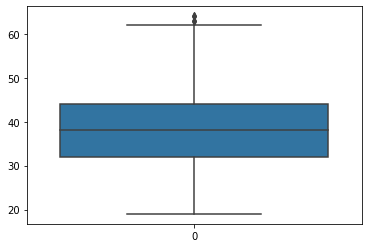

In [71]:
sb.boxplot(data=nnDf[ncdName])

<AxesSubplot:xlabel='age', ylabel='Count'>

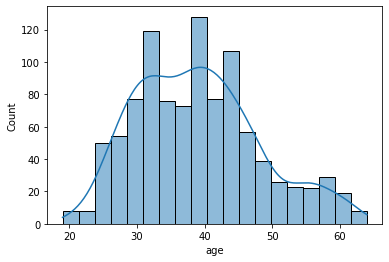

In [72]:
sb.histplot(nnDf[ncdName],  kde=True)

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

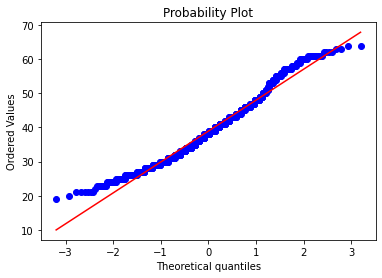

In [73]:
# 정규성 확인
stats.probplot(nnDf[ncdName], plot=plt)

In [ ]:
# (종속변수와의 상관관계)

In [74]:
# 종속변수 범주별 기초 통계량
grouped = nnDf.loc[:,[ncdName, 'fraud_reported']].groupby('fraud_reported')
grouped.describe()

age                                                   
                count       mean       std   min   25%   50%   75%   max
fraud_reported                                                          
N               753.0  38.884462  8.973139  20.0  32.0  38.0  44.0  64.0
Y               247.0  39.141700  9.648295  19.0  32.0  38.0  45.0  63.0

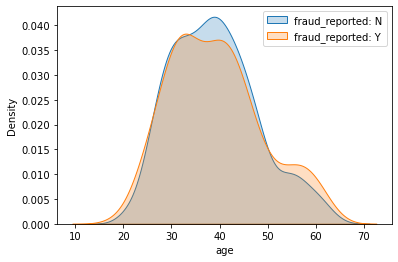

In [75]:
groups = nnDf.groupby("fraud_reported")[ncdName]

for label, group in groups:
    sb.kdeplot(group, label=f"fraud_reported: {label}", shade=True)
plt.legend()
plt.show()

In [76]:
# 유의성 검증

# 종속변수를 기준으로 나누어진 독립변수 집단
noFraud = nnDf[nnDf['fraud_reported'] == "N"][ncdName]
yesFraud = nnDf[nnDf['fraud_reported'] == "Y"][ncdName]

In [77]:
yesFraud

0      48
1      42
3      41
5      39
14     38
       ..
974    41
977    42
982    43
986    42
987    39
Name: age, Length: 247, dtype: int64

In [78]:
# 등분산 검정
stats.bartlett(noFraud, yesFraud)
# p값이 0.29이므로, 이는 유의수준 0.05보다 큼. 즉 귀무가설인 등분산이라고 판단 가능

BartlettResult(statistic=1.9955484057716553, pvalue=0.15776195182843936)

In [79]:
# t 검정
print(stats.ttest_ind(noFraud, yesFraud, equal_var=True))
# 위의 등분산이 True 이므로 equal_var=True
# p값이 0.51 이므로, 이는 유의수준 0.05보다 큼. 즉 귀무가설인 두 집단이 동일(독립변수의 변화가 종속변수에 영향을 못 줌)하다고 판단

Ttest_indResult(statistic=-0.38365092414841734, pvalue=0.7013189051151347)


In [ ]:
# (범주형 변수 파악)
# 범주형 변수를 살펴볼 때에는 아래 코드들을 사용
# >>>

In [80]:
ccdName = 'incident_severity'

In [81]:
# 기초통계량
nnDf[ccdName].describe()

count             1000
unique               4
top       Minor Damage
freq               354
Name: incident_severity, dtype: object

In [82]:
nnDf[ccdName].head

<bound method NDFrame.head of 0      Major Damage
1      Minor Damage
2      Minor Damage
3      Major Damage
4      Minor Damage
           ...     
995    Minor Damage
996    Major Damage
997    Minor Damage
998    Major Damage
999    Minor Damage
Name: incident_severity, Length: 1000, dtype: object>

In [83]:
nnDf[ccdName].unique()

array(['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'],
      dtype=object)

Minor Damage      354
Total Loss        280
Major Damage      276
Trivial Damage     90
Name: incident_severity, dtype: int64


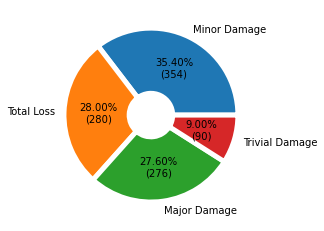

In [84]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(nnDf[ccdName].value_counts(),autopct=make_autopct(nnDf[ccdName].value_counts()), 
        labels=nnDf[ccdName].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

print(nnDf[ccdName].value_counts())

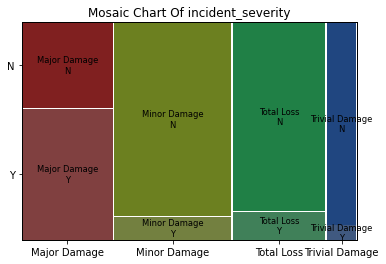

'cramer`s V : 0.514'

In [85]:
# 종속변수 yes, no에 대한 집단간 차이 알아보기
# 모자이크 플롯 및 크래머 계수
mosaic(nnDf, [ccdName, 'fraud_reported'], 

      title='Mosaic Chart Of '+ccdName)

plt.show()


f"cramer`s V : {cramerV(nnDf, ccdName, 'fraud_reported'):.3f}"

In [ ]:
# 위 까지가 기본적인 데이터 분석

# 예측 결과에 영향을 미치는 요소

# (데이터 전처리 영역)
# 1) 결측치 처리 방식
#    1. 결측 행 제거
#    2. 결측 열 제거
#    3. 결측 값 대체
#        - 범주형 데이터 : 최빈값, 연속형 데이터 : 중앙값
#        - 기본 값 설정
#        - 통계적 예측

# 2) 범례 축소 여부와 방식
#    0. 범례 축소 적용 X
#    1. 모자이크 플롯을 이용하여 시각적 판별 휴 수동 병합
#    2. 군집화를 이용한 병합

# 3) 범주형 데이터 처리 방식
#    1. 풀 랭크 더미 변수화
#    2. 축소 랭크 더미 변수화
#    3. 종속 변수 발생 빈도 사용

# 4) 차원 축소 여부와 방식
#    0. 차원 축소 적용 X
#    1. 종속 변수와 독립 변수간의 상관관계 파악 후 수동 축소
#    2. PCA 적용

# 5) 데이터 값 변형 여부와 방식
#    0. 데이터 값 변형 적용 X
#    1. 표준화
#    2. 정규화

# 6) 학습 데이터 테스트 데이터 준비 방식

# 7) 학습 데이터 불균형 처리 여부와 방식
#    0. 불균형 처리 적용 X
#    1. 언더 샘플링
#    2. 오버 샘플링
#        - 랜덤 오버샘플링(Random Over Sampling, ROS)
#        - SMOTE


# 데이터 전처리는 위 기법들의 적용 순서에도 영향을 받을수 있습니다. 
# (Ex : 데이터 결측치 처리 전후로 PCA, SMOTE 등의 결과가 달라질 수 있음)

# (모델 영역)
# 이진 분류 문제에 사용되는 대표적인 분석 모델들

# 1) 모델 종류
#    - 나이브 베이즈
#    - 로지스틱 회귀 분석
#    - 의사 결정 나무
#    - SVM
#    - DNN
#    - Random Forest
#    - XG Boost

# 2) 모델 구조 및 하이퍼 파라미터 조절

In [ ]:
#########################################################################################################################################







In [ ]:
# <4> 데이터 전처리

# 결측치를 제거한 nnDf 를 사용하여 데이터 전처리하여 cleanDf 에 할당

In [86]:
# 1 > 범주형 데이터 클래스 축소
rdclDf = nnDf.copy()


# 클래스 축소는 차원 축소 효과가 있고, one hot encoding을 할 때에도 
# 희소 벡터가 늘어나는 것을 억제해줌
# 클래스 범주를 2개로 줄일수 있다면, one hot encoding을 해도 변수가 늘어나지 않음(1 or 0의 값으로 변경 가능)

# 독립변수 33개가 존재하는 것을 가정. 위 결측치 처리에 따라 이보다 적어질 가능성이 존재
# 범주형 독립변수 종류
len(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])

16

In [ ]:
# 1) 모자이크 플롯을 이용하여 시각적 판별 후 수동 병합
# 최소 축소 개수가 2개이므로 범례가 2개 초과인 변수만 처리

In [ ]:
# <TODO>

In [ ]:
# 2) 군집화를 이용한 병합

In [ ]:
# <TODO>

In [87]:
# 1.5 > 범주형 데이터 확인 및 처리
rdDf = rdclDf.copy()

# 범주형 데이터 전처리 전 제거 가능한 범주형 변수를 제거

# 데이터 개수(row)는 양질의 데이터가 많을수록, 
# 데이터 특징(column)은 종속변수를 표현할 수 있는 필수 변수를 제외하고는 최소가 되도록 하는 것이 좋기에 원 핫 인코딩을 수행하기 전, 
# 해당 데이터가 종속 변수에 끼치는 영향과 다른 데이터들간의 상관관계를 파악해서 차원을 줄이는 것이 좋습니다.

# 데이터 확인 단계
# 1. 종속변수에 끼치는 영향을 파악
# 해당 변수가 종속변수에 끼치는 영향이 작다면 제거
# 모자이크 플롯, 크래머 계수 등으로 이를 파악

# 2. 다른 데이터들 간의 상관관계 파악
# 범주형 데이터 정보를 다른 연속형 데이터의 조합으로 표현이 가능하면 해당 범주형 컬럼은 제거하는 것이 좋음
# ex ) 운동선수 개인을 나타낼 때, 그 개인의 이름이 아니라 그 운동선수가 지금 하려는 분류 문제의 종속변수에 유의미한 영향을 끼치는
# 다른 수치형 요소들(연봉, 성별 1 or 0, 운동 성적, 나이 등...)의 조합으로 표현 가능
# 해당 변수의 범주 값을, 종속변수에서 해당 값이 나올 빈도로 나타내어 수치화 한 후 산관도 분석을 수행

# 위에서 데이터를 파악하면 이를 종합하여 해당 변수 제거 여부를 결정



# 범주형 독립변수 종류
len(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])

16

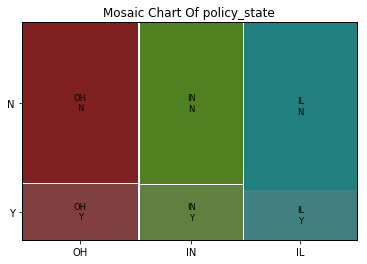

'cramer`s V : 0.032'

In [88]:
# 1. 종속변수에 끼치는 영향을 파악

# 먼저 EDA에서 보았던 범주형 독립변수와 범주형 종속 변수간의 상관관계를 파악
# 아래 결과에서 모자이크 그래프 각 컬럼별 차이가 적을수록, 크래머 계수가 작을수록 해당 변수가 종속변수에 끼치는 영향이 적음
# colName 을 원하는 범주형 변수 컬럼명으로 바꿔서 확인

colName = 'policy_state'

mosaic(rdDf, [colName, 'fraud_reported'], 

      title='Mosaic Chart Of '+colName)

plt.show()
f"cramer`s V : {cramerV(rdDf, colName, 'fraud_reported'):.3f}"

In [ ]:
# 2. 다른 데이터들 간의 상관관계 파악
# 수동으로 다른 변수들의 의미를 파악, 혹은 모종의 방식으로 이를 수치화하여 상관분석을 수행

# 여기선 종속변수 클래스가 2개 뿐이므로 수치형 변수로 변환.
# 변경하려는 범주형 변수의 각 클래스들의 값이 not fraud, 즉 사기가 아닌 상황에 발견된 횟수를 전체 발생 횟수로 나누어줍니다.
# 이는 종속 변수에 대한 발생 확률로써 수치적인 의미를 지니게 되는 것입니다.

# 참고로 이러한 계산에서 기준이 되는 종속변수 클래스는 전체 데이터에서 발생 확률이 높은 데이터, 여기서는 not fraud를 선택하는 것이
# 좋습니다. 왜냐하면 count 값이 0이 되어 뭔가 계산이 꼬이는 것을 방지하고, 희귀 케이스에서의 표본보다 의미가 있기 때문입니다.
# 뒤에서 종속변수 역시 데이터가 보다 풍부한 not fraud를 1로 해주어, 모델의 의미를 not fraud 인 확률을 구하도록 할 것입니다.


# 범주형 독립변수 종류
len(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])


In [89]:
# 임시 데이터 복사 및 종속변수 수치화
tempDf = rdDf.copy()

tempDf['fraud_reported'].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model']

In [90]:
tempDf = discreteVarToPerc(tempDf, 'fraud_reported', 
                  'N', 
                  ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])

In [91]:
tempDf

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year,fraud_reported
0,328,48,0.741477,0.737892,1000,1406.91,0,466132,0.738661,0.736111,...,1,2,0.770701,71610,6510,13020,52080,0.714286,2004,Y
1,228,42,0.745161,0.737892,2000,1197.22,5000000,468176,0.738661,0.736111,...,0,0,0.744898,5070,780,780,3510,0.740741,2007,Y
2,134,29,0.741477,0.742120,2000,1413.14,5000000,430632,0.765363,0.736000,...,2,3,0.744898,34650,7700,3850,23100,0.674419,2007,N
3,256,41,0.772189,0.737892,2000,1415.74,6000000,608117,0.765363,0.736000,...,1,2,0.744898,63400,6340,6340,50720,0.625000,2014,Y
4,228,44,0.772189,0.783333,1000,1583.91,6000000,610706,0.738661,0.765517,...,0,1,0.744898,6500,1300,650,4550,0.916667,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,0.741477,0.783333,1000,1310.80,0,431289,0.765363,0.776224,...,0,1,0.744898,87200,17440,8720,61040,0.769231,2006,N
996,285,41,0.772189,0.742120,1000,1436.79,0,608177,0.765363,0.736000,...,2,3,0.744898,108480,18080,18080,72320,0.727273,2015,N
997,130,34,0.741477,0.737892,500,1383.49,3000000,442797,0.765363,0.776224,...,2,3,0.770701,67500,7500,7500,52500,0.700000,1996,N
998,458,62,0.772189,0.783333,2000,1356.92,5000000,441714,0.738661,0.765517,...,0,1,0.770701,46980,5220,5220,36540,0.656250,1998,N


In [92]:
# 모든 독립변수가 수치화 된 것을 확인
tempDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   float64
 3   policy_csl                   1000 non-null   float64
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_zip                  1000 non-null   int64  
 8   insured_sex                  1000 non-null   float64
 9   insured_education_level      1000 non-null   float64
 10  insured_occupation           1000 non-null   float64
 11  insured_hobbies              1000 non-null   float64
 12  insured_relationship         1000 non-null   float64
 13  capital-gains      

In [93]:
# 총 변수 상관계수
tempDf.corr()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year
months_as_customer,1.000000,0.922098,-0.003332,-0.019271,0.026807,0.005018,0.015498,0.017895,-0.060925,0.010310,...,-0.005488,-0.010162,0.058383,-0.022146,0.062108,0.065329,0.034940,0.061013,-0.073110,-0.000292
age,0.922098,1.000000,0.020560,-0.014155,0.029188,0.014404,0.018126,0.025604,-0.073337,-0.012198,...,0.003408,-0.015679,0.052359,-0.020441,0.069863,0.075522,0.060898,0.062588,-0.072648,0.001354
policy_state,-0.003332,0.020560,1.000000,0.025781,0.008933,-0.010430,0.031520,-0.017409,-0.013049,-0.000632,...,0.013147,0.008808,-0.024301,-0.063198,0.003114,0.036681,-0.001982,-0.004620,-0.006506,-0.028564
policy_csl,-0.019271,-0.014155,0.025781,1.000000,0.004312,0.009373,0.000324,-0.000209,0.052628,0.091442,...,0.020249,0.010435,0.043655,-0.038370,-0.019695,-0.044371,-0.011704,-0.013075,0.041994,-0.039066
policy_deductable,0.026807,0.029188,0.008933,0.004312,1.000000,-0.003245,0.010870,0.004545,0.009733,-0.034884,...,-0.015770,-0.022765,0.066639,0.038036,0.022839,0.039107,0.064792,0.005269,0.018898,0.026105
policy_annual_premium,0.005018,0.014404,-0.010430,0.009373,-0.003245,1.000000,-0.006247,0.032354,-0.038853,0.001362,...,-0.080738,0.026780,0.002332,0.021998,0.009094,-0.017633,-0.011654,0.020246,-0.019770,-0.049226
umbrella_limit,0.015498,0.018126,0.031520,0.000324,0.010870,-0.006247,1.000000,0.019671,-0.010688,-0.021471,...,0.076358,0.022743,-0.006738,-0.044771,-0.040344,-0.045412,-0.023790,-0.038584,-0.004350,0.009893
insured_zip,0.017895,0.025604,-0.017409,-0.000209,0.004545,0.032354,0.019671,1.000000,0.036942,-0.023047,...,-0.023861,0.028695,0.019805,0.009841,-0.033873,-0.017495,-0.006841,-0.041083,-0.012108,-0.032736
insured_sex,-0.060925,-0.073337,-0.013049,0.052628,0.009733,-0.038853,-0.010688,0.036942,1.000000,0.011516,...,0.026969,0.020297,-0.042463,-0.006992,0.023727,-0.000924,0.014868,0.029609,0.013551,0.028247
insured_education_level,0.010310,-0.012198,-0.000632,0.091442,-0.034884,0.001362,-0.021471,-0.023047,0.011516,1.000000,...,-0.001234,-0.022745,0.024677,-0.020065,-0.023126,-0.046214,-0.014236,-0.016748,0.021611,0.002281


In [94]:
# 총 변수 공분산
tempDf.cov()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_model,auto_year
months_as_customer,1.325104e+04,970.201810,-5.292802e-03,-0.044249,1.888144e+03,1.410315e+02,4.098745e+06,1.476998e+05,-9.342565e-02,2.104051e-02,...,-4.688706e-03,-0.959327,7.468871,-0.030544,1.887564e+05,3.670575e+04,1.940521e+04,1.326454e+05,-0.784382,-0.202464
age,9.702018e+02,83.544841,2.593279e-03,-0.002581,1.632352e+02,3.214568e+01,3.806326e+05,1.678029e+04,-8.929501e-03,-1.976712e-03,...,2.312232e-04,-0.117534,0.531856,-0.002239,1.685908e+04,3.369297e+03,2.685543e+03,1.080424e+04,-0.061888,0.074430
policy_state,-5.292802e-03,0.002593,1.904368e-04,0.000007,7.542485e-02,-3.514206e-02,9.993054e+02,-1.722568e+01,-2.398870e-06,-1.546249e-07,...,1.346618e-06,0.000100,-0.000373,-0.000010,1.134587e+00,2.470713e+00,-1.319705e-01,-1.204155e+00,-0.000008,-0.002371
policy_csl,-4.424883e-02,-0.002581,7.096473e-06,0.000398,5.262046e-02,4.564927e-02,1.486603e+01,-2.995918e-01,1.398371e-05,3.233615e-05,...,2.997728e-06,0.000171,0.000968,-0.000009,-1.037190e+01,-4.319832e+00,-1.126381e+00,-4.925688e+00,0.000078,-0.004688
policy_deductable,1.888144e+03,163.235235,7.542485e-02,0.052620,3.743784e+05,-4.848613e+02,1.527928e+07,1.993895e+05,7.933152e-02,-3.784059e-01,...,-7.161836e-02,-11.423423,45.313313,0.278845,3.689501e+05,1.167917e+05,1.912697e+05,6.088869e+04,1.077704,96.088088
policy_annual_premium,1.410315e+02,32.145675,-3.514206e-02,0.045649,-4.848613e+02,5.961772e+04,-3.504155e+06,5.664307e+05,-1.263740e-01,5.895160e-03,...,-1.463178e-01,5.362622,0.632688,0.064354,5.862176e+04,-2.101409e+04,-1.372875e+04,9.336460e+04,-0.449914,-72.306760
umbrella_limit,4.098745e+06,380632.632633,9.993054e+02,14.866032,1.527928e+07,-3.504155e+06,5.278077e+12,3.240420e+09,-3.270822e+02,-8.745269e+02,...,1.302037e+03,42850.850851,-17204.204204,-1232.381348,-2.447073e+09,-5.092246e+08,-2.637003e+08,-1.674148e+09,-931.474038,136733.733734
insured_zip,1.476998e+05,16780.292669,-1.722568e+01,-0.299592,1.993895e+05,5.664307e+05,3.240420e+09,5.141121e+09,3.528547e+01,-2.929673e+01,...,-1.269857e+01,1687.420324,1578.175520,8.454620,-6.412337e+07,-6.122698e+06,-2.366451e+06,-5.563422e+07,-80.916919,-14120.443708
insured_sex,-9.342565e-02,-0.008930,-2.398870e-06,0.000014,7.933152e-02,-1.263740e-01,-3.270822e+02,3.528547e+01,1.774535e-04,2.719730e-06,...,2.666434e-06,0.000222,-0.000629,-0.000001,8.344731e+00,-6.004766e-02,9.555843e-01,7.449194e+00,0.000017,0.002264
insured_education_level,2.104051e-02,-0.001977,-1.546249e-07,0.000032,-3.784059e-01,5.895160e-03,-8.745269e+02,-2.929673e+01,2.719730e-06,3.143094e-04,...,-1.624203e-07,-0.000331,0.000486,-0.000004,-1.082441e+01,-3.999033e+00,-1.217740e+00,-5.607639e+00,0.000036,0.000243


<AxesSubplot:>

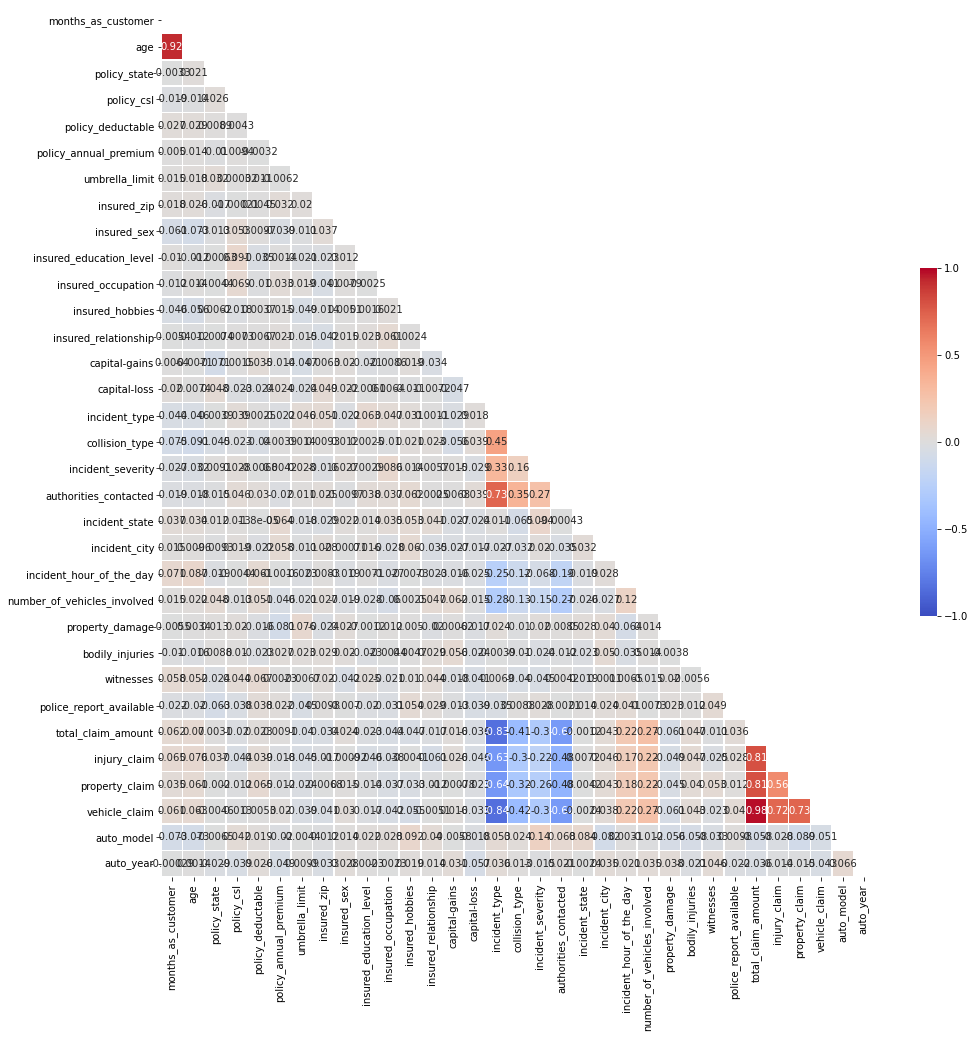

In [95]:
plt.figure(figsize=(16, 16))

corr_matrix = tempDf.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
sb.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
           mask = mask,
           cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},
           vmin = -1,
           vmax = 1,
            cmap='coolwarm',
            annot=True,
            linewidth=0.5)

In [ ]:
# 위와 같이 데이터를 파악.
# 결국 위에서는 크래머 계수가 작고, 상관계수가 큰 범주형 변수라면 제거가 가능하다고 결론지을 수 있습니다.
# 범주형 독립변수 종류
len(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])
# 에서, 상관관계가 두드러지는(절대값 0.2가 넘는) 변수로는,

# incident_type(cramer`s V : 0.171), collision_type(cramer`s V : 0.046), 
# incident_severity(cramer`s V : 0.514), authorities_contacted(cramer`s V : 0.162)

# 위와 같습니다.

# 꼭 위와 같은 기준이 아닌 개인적인 기준에 따라 변수를 제거하거나 하지 않아도 됩니다.



In [ ]:
# 3. 범주형 데이터 변환 전 처리

# 여기까지 파악해서 제거하려면,






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 확인 처리 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [96]:
rdDf.columns

Index(['months_as_customer', 'age', 'policy_state', 'policy_csl',
       'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_model',
       'auto_year', 'fraud_reported'],
      dtype='object')

In [97]:
# 제거하려는 컬럼명
deleteColName = ['number_of_vehicles_involved', 'injury_claim', 'property_claim',
       'vehicle_claim', 'age']

rdDf = rdDf.drop(deleteColName, axis=1)

rdDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,328,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,...,Columbus,5,YES,1,2,YES,71610,92x,2004,Y
1,228,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,...,Riverwood,8,NO,0,0,NO,5070,E400,2007,Y
2,134,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,...,Columbus,7,NO,2,3,NO,34650,RAM,2007,N
3,256,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,...,Arlington,5,NO,1,2,NO,63400,Tahoe,2014,Y
4,228,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,...,Arlington,20,NO,0,1,NO,6500,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,...,Northbrook,20,YES,0,1,NO,87200,Accord,2006,N
996,285,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,...,Northbend,23,YES,2,3,NO,108480,Passat,2015,N
997,130,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,...,Arlington,4,NO,2,3,YES,67500,Impreza,1996,N
998,458,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,...,Arlington,2,NO,0,1,YES,46980,A5,1998,N


In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 확인 처리 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 2 > 범주형 데이터 전처리
# 독립변수 33개가 존재하는 것을 가정. 위 결측치 처리에 따라 이보다 적어질 가능성이 존재
# 범주형 독립변수 종류
len(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])

In [102]:
ndiscVarDf = rdDf.copy()
ndiscVarDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,328,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,...,Columbus,5,YES,1,2,YES,71610,92x,2004,Y
1,228,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,...,Riverwood,8,NO,0,0,NO,5070,E400,2007,Y
2,134,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,...,Columbus,7,NO,2,3,NO,34650,RAM,2007,N
3,256,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,...,Arlington,5,NO,1,2,NO,63400,Tahoe,2014,Y
4,228,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,...,Arlington,20,NO,0,1,NO,6500,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,...,Northbrook,20,YES,0,1,NO,87200,Accord,2006,N
996,285,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,...,Northbend,23,YES,2,3,NO,108480,Passat,2015,N
997,130,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,...,Arlington,4,NO,2,3,YES,67500,Impreza,1996,N
998,458,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,...,Arlington,2,NO,0,1,YES,46980,A5,1998,N


In [ ]:
# 1) 더미 변수화
# one hot encoding 과 동일
# drop_first 를 True로 두면 축소 랭크 방식,
# 기본값인 풀 랭크 인코딩을 하면, 변수가 클래스 개수만큼 늘어나지만,
# 축소 랭크 방식을 사용하면, 클래스 개수 -1 개 만큼 늘어남.
# 나머지 클래스를 알면 남은 하나의 클래스를 알 수 있을 때 사용





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 전처리  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [99]:
# 독립변수 분리
ndiscVarDf_x = ndiscVarDf.loc[:, ndiscVarDf.columns!="fraud_reported"]
ndiscVarDf_y = ndiscVarDf.loc[:, ndiscVarDf.columns=="fraud_reported"]
ndiscVarDf_x

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_state,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year
0,328,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,...,SC,Columbus,5,YES,1,2,YES,71610,92x,2004
1,228,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,...,VA,Riverwood,8,NO,0,0,NO,5070,E400,2007
2,134,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,...,NY,Columbus,7,NO,2,3,NO,34650,RAM,2007
3,256,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,...,OH,Arlington,5,NO,1,2,NO,63400,Tahoe,2014
4,228,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,...,NY,Arlington,20,NO,0,1,NO,6500,RSX,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,...,NC,Northbrook,20,YES,0,1,NO,87200,Accord,2006
996,285,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,...,SC,Northbend,23,YES,2,3,NO,108480,Passat,2015
997,130,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,...,NC,Arlington,4,NO,2,3,YES,67500,Impreza,1996
998,458,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,...,NY,Arlington,2,NO,0,1,YES,46980,A5,1998


In [100]:
ndiscVarDf_x = pd.get_dummies(ndiscVarDf_x, drop_first=True)
ndiscVarDf = pd.concat([ndiscVarDf_x, ndiscVarDf_y], axis = 1)
ndiscVarDf

,months_as_customer,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,bodily_injuries,witnesses,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,328,1000,1406.91,0,466132,53300,0,5,1,2,...,0,0,0,0,0,0,0,0,0,Y
1,228,2000,1197.22,5000000,468176,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,Y
2,134,2000,1413.14,5000000,430632,35100,0,7,2,3,...,1,0,0,0,0,0,0,0,0,N
3,256,2000,1415.74,6000000,608117,48900,-62400,5,1,2,...,0,0,0,0,1,0,0,0,0,Y
4,228,1000,1583.91,6000000,610706,66000,-46000,20,0,1,...,0,1,0,0,0,0,0,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,1000,1310.80,0,431289,0,0,20,0,1,...,0,0,0,0,0,0,0,0,0,N
996,285,1000,1436.79,0,608177,70900,0,23,2,3,...,0,0,0,0,0,0,0,0,0,N
997,130,500,1383.49,3000000,442797,35100,0,4,2,3,...,0,0,0,0,0,0,0,0,0,N
998,458,2000,1356.92,5000000,441714,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,N


In [101]:
ndiscVarDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 125 entries, months_as_customer to fraud_reported
dtypes: float64(1), int64(11), object(1), uint8(112)
memory usage: 211.1+ KB


In [ ]:





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 전처리 1 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 2) 발생 빈도로 변환
# 종속변수의 특정 상황일 때에 해당하는 범주형 독립변수 상태값이 발견된 빈도로 수치화를 합니다.
# 예를들면 종속변수가 yes 일 때에 독립변수 cls1 의 값이 0.58 빈도로 발생했다면, cls1 = 0.58 이라고 하고, 추후 cls1 이라는 값이 들어오면 
# 0.58이라고 바꿔줍니다.
# 이 방식은 해당 변수값이 종속변수 특정 값에 끼치는 영향을 수치로 나타낸 것이라 독립 변수로써 유의미한 의미를 지니고,
# 차원이 늘어나지 않는 장점을 지니지만,
# 이를 계산하는 시점에 샘플의 개수가 적거나, 기준이 될 종속변수의 클래스가 서로 독립적이며 다양할수록 사용하기 어렵습니다.





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 전처리 2  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [103]:
# 종속변수 fraud_reported 에 대해 N 가 나왔을 때의 발생 빈도를 사용하여 범주 값을 수치화

ndiscVarDf = discreteVarToPerc(ndiscVarDf, 'fraud_reported', 
                  'N', 
                  ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
     'insured_relationship','incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 
     'incident_city', 'property_damage','police_report_available', 'auto_model'])
ndiscVarDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,328,0.741477,0.737892,1000,1406.91,0,466132,0.738661,0.736111,0.702703,...,0.738255,5,0.741722,1,2,0.770701,71610,0.714286,2004,Y
1,228,0.745161,0.737892,2000,1197.22,5000000,468176,0.738661,0.736111,0.763441,...,0.776119,8,0.757880,0,0,0.744898,5070,0.740741,2007,Y
2,134,0.741477,0.742120,2000,1413.14,5000000,430632,0.765363,0.736000,0.723684,...,0.738255,7,0.757880,2,3,0.744898,34650,0.674419,2007,N
3,256,0.772189,0.737892,2000,1415.74,6000000,608117,0.765363,0.736000,0.753623,...,0.710526,5,0.757880,1,2,0.744898,63400,0.625000,2014,Y
4,228,0.772189,0.783333,1000,1583.91,6000000,610706,0.738661,0.765517,0.723684,...,0.710526,20,0.757880,0,1,0.744898,6500,0.916667,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0.741477,0.783333,1000,1310.80,0,431289,0.765363,0.776224,0.702703,...,0.778689,20,0.741722,0,1,0.744898,87200,0.769231,2006,N
996,285,0.772189,0.742120,1000,1436.79,0,608177,0.765363,0.736000,0.788235,...,0.765517,23,0.741722,2,3,0.744898,108480,0.727273,2015,N
997,130,0.741477,0.737892,500,1383.49,3000000,442797,0.765363,0.776224,0.753623,...,0.710526,4,0.757880,2,3,0.770701,67500,0.700000,1996,N
998,458,0.772189,0.783333,2000,1356.92,5000000,441714,0.738661,0.765517,0.796296,...,0.710526,2,0.757880,0,1,0.770701,46980,0.656250,1998,N


In [104]:
# 종속변수를 제외하고 모두 숫자 데이터로 바뀐 것을 확인
ndiscVarDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   months_as_customer        1000 non-null   int64  
 1   policy_state              1000 non-null   float64
 2   policy_csl                1000 non-null   float64
 3   policy_deductable         1000 non-null   int64  
 4   policy_annual_premium     1000 non-null   float64
 5   umbrella_limit            1000 non-null   int64  
 6   insured_zip               1000 non-null   int64  
 7   insured_sex               1000 non-null   float64
 8   insured_education_level   1000 non-null   float64
 9   insured_occupation        1000 non-null   float64
 10  insured_hobbies           1000 non-null   float64
 11  insured_relationship      1000 non-null   float64
 12  capital-gains             1000 non-null   int64  
 13  capital-loss              1000 non-null   int64  
 14  incident_

In [ ]:





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 범주형 데이터 전처리 2 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [105]:
# 3 > 차원 축소
# ndiscVarDf 로 비이산형(not discrete) 변수가 준비됨
reduceVarDf = ndiscVarDf.copy()
reduceVarDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,328,0.741477,0.737892,1000,1406.91,0,466132,0.738661,0.736111,0.702703,...,0.738255,5,0.741722,1,2,0.770701,71610,0.714286,2004,Y
1,228,0.745161,0.737892,2000,1197.22,5000000,468176,0.738661,0.736111,0.763441,...,0.776119,8,0.757880,0,0,0.744898,5070,0.740741,2007,Y
2,134,0.741477,0.742120,2000,1413.14,5000000,430632,0.765363,0.736000,0.723684,...,0.738255,7,0.757880,2,3,0.744898,34650,0.674419,2007,N
3,256,0.772189,0.737892,2000,1415.74,6000000,608117,0.765363,0.736000,0.753623,...,0.710526,5,0.757880,1,2,0.744898,63400,0.625000,2014,Y
4,228,0.772189,0.783333,1000,1583.91,6000000,610706,0.738661,0.765517,0.723684,...,0.710526,20,0.757880,0,1,0.744898,6500,0.916667,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0.741477,0.783333,1000,1310.80,0,431289,0.765363,0.776224,0.702703,...,0.778689,20,0.741722,0,1,0.744898,87200,0.769231,2006,N
996,285,0.772189,0.742120,1000,1436.79,0,608177,0.765363,0.736000,0.788235,...,0.765517,23,0.741722,2,3,0.744898,108480,0.727273,2015,N
997,130,0.741477,0.737892,500,1383.49,3000000,442797,0.765363,0.776224,0.753623,...,0.710526,4,0.757880,2,3,0.770701,67500,0.700000,1996,N
998,458,0.772189,0.783333,2000,1356.92,5000000,441714,0.738661,0.765517,0.796296,...,0.710526,2,0.757880,0,1,0.770701,46980,0.656250,1998,N


In [ ]:
# 수동 축소
# 데이터 분석 결과에 따라 차원 축소






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 차원 축소 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 제거하려는 컬럼명
deleteColName2 = ['number_of_vehicles_involved']

reduceVarDf = reduceVarDf.drop(deleteColName2, axis=1)

reduceVarDf

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 차원 축소 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# PCA 적용
# 연속형 데이터들을 주성분만으로 이루어진 변수의 집합으로 바꿉니다.
# PCA를 적용하면 주성분에는 저절로 표준화(평균 0, 표준편차 1)를 수행합니다.

In [106]:
reduceVarDf_x = reduceVarDf.loc[:, reduceVarDf.columns!="fraud_reported"]
reduceVarDf_y = reduceVarDf.loc[:, reduceVarDf.columns=="fraud_reported"]
reduceVarDf_y

,fraud_reported
0,Y
1,Y
2,N
3,Y
4,N
...,...
995,N
996,N
997,N
998,N


In [107]:
reduceVarDf_x = (reduceVarDf_x - reduceVarDf_x.mean()) / reduceVarDf_x.std()
reduceVarDf_x

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_state,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year
0,1.077600,-0.834987,-0.757442,-0.222271,0.616396,-0.479236,-0.489285,-1.076414,-0.952626,-0.877191,...,-0.864162,-0.668832,-0.955782,-1.519522,0.009755,0.461607,1.477338,0.713900,-0.415379,-0.183349
1,0.208890,-0.568027,-0.757442,1.412077,-0.242400,1.697131,-0.460777,-1.076414,-0.952626,0.182090,...,0.359996,1.048697,-0.524213,0.657444,-1.209568,-1.338030,-0.676216,-1.806408,-0.131534,0.315333
2,-0.607698,-0.834987,-0.545444,1.412077,0.641911,1.697131,-0.984392,0.928081,-0.958893,-0.511271,...,0.467639,-0.668832,-0.668069,0.657444,1.229078,1.361425,-0.676216,-0.686018,-0.843126,0.315333
3,0.452129,1.390544,-0.757442,1.412077,0.652560,2.132404,1.490936,0.928081,-0.958893,0.010868,...,-3.426778,-1.926608,-0.955782,0.657444,0.009755,0.461607,-0.676216,0.402933,-1.373355,1.478924
4,0.208890,1.390544,1.520739,-0.222271,1.341309,2.132404,1.527044,-1.076414,0.706041,-0.511271,...,0.467639,-1.926608,1.202065,0.657444,-1.209568,-0.438212,-0.676216,-1.752244,1.756035,0.647788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.745708,-0.834987,1.520739,-0.222271,0.222773,-0.479236,-0.975229,0.928081,1.309948,-0.877191,...,-1.133075,1.165233,1.202065,-1.519522,-1.209568,-0.438212,-0.676216,1.304396,0.174145,0.149106
996,0.704055,1.390544,-0.545444,-0.222271,0.738771,-0.479236,1.491773,0.928081,-0.958893,0.614508,...,-0.864162,0.567783,1.633634,-1.519522,1.229078,1.361425,-0.676216,2.110410,-0.276037,1.645151
997,-0.642446,-0.834987,-0.757442,-1.039446,0.520478,0.826584,-0.814730,0.928081,1.309948,0.010868,...,-1.133075,-1.926608,-1.099639,0.657444,1.229078,1.361425,1.477338,0.558227,-0.568655,-1.513167
998,2.206924,1.390544,1.520739,1.412077,0.411660,1.697131,-0.829835,-1.076414,0.706041,0.755093,...,0.467639,-1.926608,-1.387352,0.657444,-1.209568,-0.438212,1.477338,-0.219000,-1.038063,-1.180712


In [108]:
pca = PCA(n_components=reduceVarDf_x.shape[1])
pca.fit(reduceVarDf_x)

PCA(n_components=28)

In [109]:
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(reduceVarDf_x.columns))],
index=reduceVarDf_x.columns)
print(loadings)

                               PC0       PC1       PC2       PC3       PC4  \
months_as_customer       -0.057880  0.129416 -0.122820  0.007387 -0.361166   
policy_state             -0.007219  0.058562  0.360753 -0.085734 -0.104485   
policy_csl                0.029748 -0.176657  0.220985 -0.147026 -0.301994   
policy_deductable        -0.012580 -0.098971 -0.303286 -0.074873 -0.045226   
policy_annual_premium    -0.012879 -0.055387  0.083717  0.502772 -0.254306   
umbrella_limit            0.032913  0.141136  0.127306 -0.309774 -0.170599   
insured_zip               0.022227  0.222300 -0.084597  0.224732 -0.055731   
insured_sex              -0.001356 -0.114922  0.121669 -0.137805  0.157222   
insured_education_level   0.032812 -0.120550  0.108177 -0.058513 -0.240328   
insured_occupation        0.048162 -0.250198  0.273339 -0.058267 -0.120814   
insured_hobbies           0.042511 -0.302893 -0.137960  0.187692  0.038531   
insured_relationship      0.014767 -0.231391  0.048600  0.041860

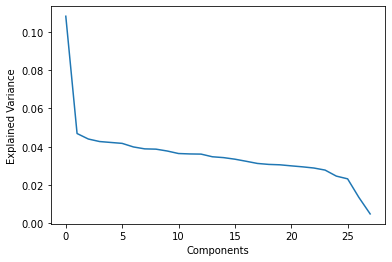

In [110]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [111]:
# 주성분의 데이터 설명 비율 확인
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
print(per_var.sum())
per_var ## 총분산값을 보여준다.
## 순서데로, PC1의 요소의 Var 값이다.

100.10000000000001


array([10.8,  4.7,  4.4,  4.3,  4.2,  4.2,  4. ,  3.9,  3.9,  3.8,  3.6,
        3.6,  3.6,  3.5,  3.4,  3.3,  3.2,  3.1,  3.1,  3.1,  3. ,  3. ,
        2.9,  2.8,  2.5,  2.3,  1.4,  0.5])

In [ ]:
# 위는 120 독립변수를 120 주성분으로 만든 것.
# 본격적으로 주성분 설명 비율을 설정해서 추출

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 차원 축소 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 데이터 설명 비율을 0.8로 설정

pca = PCA(n_components=0.8)
pcaTrans = pca.fit_transform(reduceVarDf_x)
pcaTrans

In [ ]:
# 주성분의 데이터 설명 비율 확인
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
print(per_var.sum())
per_var ## 총분산값을 보여준다.
## 순서데로, PC1의 요소의 Var 값이다.

In [ ]:
# 각 PC가 무슨 변수에 영향을 받았는지를 확인

 ## pca.components_[0] 첫번째 고유벡터, 원하는 주성분 인덱스를 넣어주면 됨
loading_scores = pd.Series(pca.components_[0], index=reduceVarDf_x.columns)
# 영향력의 절대값이 큰 순서대로 정렬
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# 영향력 top 10을 선정
top_10_genes = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_genes])

In [ ]:
pc_x = pd.DataFrame(data = pcaTrans, columns = ['PC '+str(i) for i in range(1,pcaTrans.shape[1]+1)])
pc_x

In [ ]:
reduceVarDf = pd.concat([pc_x, reduceVarDf_y], axis = 1)
reduceVarDf

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 차원 축소 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [112]:
# 4 > 표준화, 정규화
clearDf = reduceVarDf.copy()
clearDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,328,0.741477,0.737892,1000,1406.91,0,466132,0.738661,0.736111,0.702703,...,0.738255,5,0.741722,1,2,0.770701,71610,0.714286,2004,Y
1,228,0.745161,0.737892,2000,1197.22,5000000,468176,0.738661,0.736111,0.763441,...,0.776119,8,0.757880,0,0,0.744898,5070,0.740741,2007,Y
2,134,0.741477,0.742120,2000,1413.14,5000000,430632,0.765363,0.736000,0.723684,...,0.738255,7,0.757880,2,3,0.744898,34650,0.674419,2007,N
3,256,0.772189,0.737892,2000,1415.74,6000000,608117,0.765363,0.736000,0.753623,...,0.710526,5,0.757880,1,2,0.744898,63400,0.625000,2014,Y
4,228,0.772189,0.783333,1000,1583.91,6000000,610706,0.738661,0.765517,0.723684,...,0.710526,20,0.757880,0,1,0.744898,6500,0.916667,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0.741477,0.783333,1000,1310.80,0,431289,0.765363,0.776224,0.702703,...,0.778689,20,0.741722,0,1,0.744898,87200,0.769231,2006,N
996,285,0.772189,0.742120,1000,1436.79,0,608177,0.765363,0.736000,0.788235,...,0.765517,23,0.741722,2,3,0.744898,108480,0.727273,2015,N
997,130,0.741477,0.737892,500,1383.49,3000000,442797,0.765363,0.776224,0.753623,...,0.710526,4,0.757880,2,3,0.770701,67500,0.700000,1996,N
998,458,0.772189,0.783333,2000,1356.92,5000000,441714,0.738661,0.765517,0.796296,...,0.710526,2,0.757880,0,1,0.770701,46980,0.656250,1998,N


In [113]:
# 계산에 사용할 독립변수 분리
clearDf_x = clearDf.loc[:, clearDf.columns!="fraud_reported"]
clearDf_y = clearDf.loc[:, clearDf.columns=="fraud_reported"]
clearDf_x

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_state,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year
0,328,0.741477,0.737892,1000,1406.91,0,466132,0.738661,0.736111,0.702703,...,0.705645,0.738255,5,0.741722,1,2,0.770701,71610,0.714286,2004
1,228,0.745161,0.737892,2000,1197.22,5000000,468176,0.738661,0.736111,0.763441,...,0.772727,0.776119,8,0.757880,0,0,0.744898,5070,0.740741,2007
2,134,0.741477,0.742120,2000,1413.14,5000000,430632,0.765363,0.736000,0.723684,...,0.778626,0.738255,7,0.757880,2,3,0.744898,34650,0.674419,2007
3,256,0.772189,0.737892,2000,1415.74,6000000,608117,0.765363,0.736000,0.753623,...,0.565217,0.710526,5,0.757880,1,2,0.744898,63400,0.625000,2014
4,228,0.772189,0.783333,1000,1583.91,6000000,610706,0.738661,0.765517,0.723684,...,0.778626,0.710526,20,0.757880,0,1,0.744898,6500,0.916667,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0.741477,0.783333,1000,1310.80,0,431289,0.765363,0.776224,0.702703,...,0.690909,0.778689,20,0.741722,0,1,0.744898,87200,0.769231,2006
996,285,0.772189,0.742120,1000,1436.79,0,608177,0.765363,0.736000,0.788235,...,0.705645,0.765517,23,0.741722,2,3,0.744898,108480,0.727273,2015
997,130,0.741477,0.737892,500,1383.49,3000000,442797,0.765363,0.776224,0.753623,...,0.690909,0.710526,4,0.757880,2,3,0.770701,67500,0.700000,1996
998,458,0.772189,0.783333,2000,1356.92,5000000,441714,0.738661,0.765517,0.796296,...,0.778626,0.710526,2,0.757880,0,1,0.770701,46980,0.656250,1998


In [ ]:
# 표준화 : (x1 - 평균) / 표준편차





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 표준화 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [114]:
clearDf_x = (clearDf_x - clearDf_x.mean()) / clearDf_x.std()
clearDf = pd.concat([clearDf_x, clearDf_y], axis = 1)
clearDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,1.077600,-0.834987,-0.757442,-0.222271,0.616396,-0.479236,-0.489285,-1.076414,-0.952626,-0.877191,...,-0.668832,-0.955782,-1.519522,0.009755,0.461607,1.477338,0.713900,-0.415379,-0.183349,Y
1,0.208890,-0.568027,-0.757442,1.412077,-0.242400,1.697131,-0.460777,-1.076414,-0.952626,0.182090,...,1.048697,-0.524213,0.657444,-1.209568,-1.338030,-0.676216,-1.806408,-0.131534,0.315333,Y
2,-0.607698,-0.834987,-0.545444,1.412077,0.641911,1.697131,-0.984392,0.928081,-0.958893,-0.511271,...,-0.668832,-0.668069,0.657444,1.229078,1.361425,-0.676216,-0.686018,-0.843126,0.315333,N
3,0.452129,1.390544,-0.757442,1.412077,0.652560,2.132404,1.490936,0.928081,-0.958893,0.010868,...,-1.926608,-0.955782,0.657444,0.009755,0.461607,-0.676216,0.402933,-1.373355,1.478924,Y
4,0.208890,1.390544,1.520739,-0.222271,1.341309,2.132404,1.527044,-1.076414,0.706041,-0.511271,...,-1.926608,1.202065,0.657444,-1.209568,-0.438212,-0.676216,-1.752244,1.756035,0.647788,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.745708,-0.834987,1.520739,-0.222271,0.222773,-0.479236,-0.975229,0.928081,1.309948,-0.877191,...,1.165233,1.202065,-1.519522,-1.209568,-0.438212,-0.676216,1.304396,0.174145,0.149106,N
996,0.704055,1.390544,-0.545444,-0.222271,0.738771,-0.479236,1.491773,0.928081,-0.958893,0.614508,...,0.567783,1.633634,-1.519522,1.229078,1.361425,-0.676216,2.110410,-0.276037,1.645151,N
997,-0.642446,-0.834987,-0.757442,-1.039446,0.520478,0.826584,-0.814730,0.928081,1.309948,0.010868,...,-1.926608,-1.099639,0.657444,1.229078,1.361425,1.477338,0.558227,-0.568655,-1.513167,N
998,2.206924,1.390544,1.520739,1.412077,0.411660,1.697131,-0.829835,-1.076414,0.706041,0.755093,...,-1.926608,-1.387352,0.657444,-1.209568,-0.438212,1.477338,-0.219000,-1.038063,-1.180712,N


In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 표준화 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 정규화 : (x1 - min) / (max - min)





#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 정규화 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [115]:
clearDf_x = (clearDf_x - clearDf_x.min()) / ( clearDf_x.max() - clearDf_x.min())
clearDf = pd.concat([clearDf_x, clearDf_y], axis = 1)
clearDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.684760,0.000000,0.000000,0.333333,0.603112,0.090909,0.188769,0.0,0.002762,0.356676,...,0.406805,0.217391,0.0,0.5,0.666667,1.0,0.622801,0.397403,0.45,Y
1,0.475992,0.119953,0.000000,1.000000,0.473214,0.545455,0.199478,0.0,0.002762,0.661270,...,0.962309,0.347826,1.0,0.0,0.000000,0.0,0.043285,0.466667,0.60,Y
2,0.279749,0.000000,0.093056,1.000000,0.606972,0.545455,0.002766,1.0,0.000000,0.461896,...,0.406805,0.304348,1.0,1.0,1.000000,0.0,0.300906,0.293023,0.60,N
3,0.534447,1.000000,0.000000,1.000000,0.608582,0.636364,0.932699,1.0,0.000000,0.612036,...,0.000000,0.217391,1.0,0.5,0.666667,0.0,0.551298,0.163636,0.95,Y
4,0.475992,1.000000,1.000000,0.333333,0.712760,0.636364,0.946264,0.0,0.733826,0.461896,...,0.000000,0.869565,1.0,0.0,0.333333,0.0,0.055739,0.927273,0.70,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.006263,0.000000,1.000000,0.333333,0.543574,0.090909,0.006209,1.0,1.000000,0.356676,...,1.000000,0.869565,0.0,0.0,0.333333,0.0,0.758579,0.541259,0.55,N
996,0.594990,1.000000,0.093056,0.333333,0.621622,0.090909,0.933013,1.0,0.000000,0.785611,...,0.806766,1.000000,0.0,1.0,1.000000,0.0,0.943912,0.431405,1.00,N
997,0.271399,0.000000,0.000000,0.000000,0.588604,0.363636,0.066505,1.0,1.000000,0.612036,...,0.000000,0.173913,1.0,1.0,1.000000,1.0,0.587006,0.360000,0.05,N
998,0.956159,1.000000,1.000000,1.000000,0.572145,0.545455,0.060831,0.0,0.733826,0.826036,...,0.000000,0.086957,1.0,0.0,0.333333,1.0,0.408291,0.245455,0.15,N


In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 정규화 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 5 > 종속변수 수치화
# 종속변수를 수치화 합니다.
# 이진분류이므로 한 클래스를 알면 다른 클래스를 알수 있으므로 한 클래스에 대한 등장 확률로써 수치화합니다.
# 간단히 말하자면 not fraud(표본이 많은 데이터)가 1, fraud 가 0 입니다.

In [116]:
dVarNumDf = clearDf.copy()
dVarNumDf['fraud_reported']

0      Y
1      Y
2      N
3      Y
4      N
      ..
995    N
996    N
997    N
998    N
999    N
Name: fraud_reported, Length: 1000, dtype: object

In [117]:
dVarNumDf['fraud_reported'] = dVarNumDf['fraud_reported'].replace('N', 1)
dVarNumDf['fraud_reported'] = dVarNumDf['fraud_reported'].replace('Y', 0)
dVarNumDf['fraud_reported']

0      0
1      0
2      1
3      0
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: fraud_reported, Length: 1000, dtype: int64

In [118]:
# 5 > 학습 데이터와 테스트 데이터 분할
ttDf = dVarNumDf.copy()
ttDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.684760,0.000000,0.000000,0.333333,0.603112,0.090909,0.188769,0.0,0.002762,0.356676,...,0.406805,0.217391,0.0,0.5,0.666667,1.0,0.622801,0.397403,0.45,0
1,0.475992,0.119953,0.000000,1.000000,0.473214,0.545455,0.199478,0.0,0.002762,0.661270,...,0.962309,0.347826,1.0,0.0,0.000000,0.0,0.043285,0.466667,0.60,0
2,0.279749,0.000000,0.093056,1.000000,0.606972,0.545455,0.002766,1.0,0.000000,0.461896,...,0.406805,0.304348,1.0,1.0,1.000000,0.0,0.300906,0.293023,0.60,1
3,0.534447,1.000000,0.000000,1.000000,0.608582,0.636364,0.932699,1.0,0.000000,0.612036,...,0.000000,0.217391,1.0,0.5,0.666667,0.0,0.551298,0.163636,0.95,0
4,0.475992,1.000000,1.000000,0.333333,0.712760,0.636364,0.946264,0.0,0.733826,0.461896,...,0.000000,0.869565,1.0,0.0,0.333333,0.0,0.055739,0.927273,0.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.006263,0.000000,1.000000,0.333333,0.543574,0.090909,0.006209,1.0,1.000000,0.356676,...,1.000000,0.869565,0.0,0.0,0.333333,0.0,0.758579,0.541259,0.55,1
996,0.594990,1.000000,0.093056,0.333333,0.621622,0.090909,0.933013,1.0,0.000000,0.785611,...,0.806766,1.000000,0.0,1.0,1.000000,0.0,0.943912,0.431405,1.00,1
997,0.271399,0.000000,0.000000,0.000000,0.588604,0.363636,0.066505,1.0,1.000000,0.612036,...,0.000000,0.173913,1.0,1.0,1.000000,1.0,0.587006,0.360000,0.05,1
998,0.956159,1.000000,1.000000,1.000000,0.572145,0.545455,0.060831,0.0,0.733826,0.826036,...,0.000000,0.086957,1.0,0.0,0.333333,1.0,0.408291,0.245455,0.15,1


In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 학습 데이터와 테스트 데이터 분할 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [119]:
# test_size 로 학습 / 테스트 비율을 변경

ttDf_x_data = ttDf.drop(['fraud_reported'],axis=1)
ttDf_y_data = ttDf['fraud_reported']

x_trainDf, x_testDf, y_trainDf, y_testDf = train_test_split(ttDf_x_data, 
                                                            ttDf_y_data, 
                                                            test_size=0.2,  
                                                            stratify=ttDf_y_data)
ttDf_train = pd.concat([pd.DataFrame(x_trainDf), pd.DataFrame(y_trainDf)], axis = 1)
ttDf_test = pd.concat([pd.DataFrame(x_testDf), pd.DataFrame(y_testDf)], axis = 1)

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 학습 데이터와 테스트 데이터 분할 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [120]:
ttDf_train

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
932,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.695920,0.173913,1.0,1.0,0.333333,1.0,0.446786,0.193388,0.05,1
6,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.695920,0.000000,1.0,0.0,0.000000,0.0,0.684114,0.807625,0.85,1
210,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.605126,0.304348,1.0,1.0,0.000000,0.0,0.052430,0.752727,1.00,1
151,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.605126,0.173913,1.0,1.0,0.333333,0.0,0.417697,0.127273,0.70,1
437,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.0,1.0,0.666667,0.0,0.054868,0.098182,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,0.778706,0.119953,0.000000,0.000000,0.727287,0.090909,0.076088,0.0,0.002762,0.461896,...,0.000000,0.913043,1.0,0.0,0.666667,0.0,0.526912,0.293023,0.60,0
60,0.321503,0.119953,0.093056,0.000000,0.224189,0.090909,0.938457,0.0,0.000000,0.661270,...,0.695920,0.652174,0.0,1.0,0.333333,0.0,0.604250,0.381818,0.95,0
787,0.277662,0.119953,1.000000,0.333333,0.494146,0.090909,0.154345,0.0,0.042386,0.998913,...,0.962309,0.826087,1.0,0.5,0.666667,0.0,0.246821,0.720885,0.60,1
345,0.179541,0.119953,0.093056,1.000000,0.719673,0.090909,0.048203,0.0,0.000000,0.384913,...,0.605126,0.826087,0.0,0.0,0.666667,1.0,0.616791,0.833766,0.35,1


In [121]:
ttDf_test

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
424,0.313152,0.119953,1.000000,0.333333,0.570645,0.090909,0.138836,0.0,1.000000,0.661270,...,0.000000,0.260870,1.0,0.0,1.000000,1.0,0.563491,0.397403,0.25,0
116,0.223382,1.000000,1.000000,1.000000,0.582861,0.090909,0.212194,1.0,0.000000,0.661270,...,0.605126,0.695652,1.0,0.0,1.000000,0.0,0.445567,0.736364,0.35,1
335,0.252610,1.000000,1.000000,0.333333,0.389435,0.636364,0.056236,1.0,0.077825,0.612036,...,0.605126,0.695652,1.0,0.0,0.333333,1.0,0.567410,1.000000,0.35,1
559,0.405010,0.119953,0.093056,1.000000,0.494295,0.090909,0.912872,1.0,0.000000,0.356676,...,0.000000,0.652174,1.0,0.5,0.000000,0.0,0.466643,0.771429,0.80,1
97,0.060543,1.000000,0.000000,1.000000,0.569611,0.090909,0.182623,0.0,1.000000,0.333661,...,0.605126,0.173913,0.0,0.5,0.666667,1.0,0.564275,0.807625,0.90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0.743215,0.119953,0.000000,1.000000,0.447660,0.090909,0.005239,0.0,0.969576,0.785611,...,0.406805,0.217391,0.0,0.0,1.000000,0.0,0.534663,0.293023,0.70,1
283,0.910230,0.000000,0.000000,1.000000,0.603174,0.545455,0.238926,0.0,0.000000,0.433133,...,0.962309,0.434783,1.0,0.0,0.666667,0.0,0.520815,0.348617,0.10,0
599,0.498956,0.000000,0.000000,0.333333,0.522468,0.545455,0.943854,1.0,1.000000,0.826036,...,1.000000,0.521739,1.0,0.5,1.000000,0.0,0.538408,0.621818,0.40,1
615,0.319415,1.000000,0.000000,0.000000,0.345706,0.090909,0.100368,0.0,0.969576,0.433133,...,0.695920,0.000000,1.0,0.5,0.000000,0.0,0.676450,0.807625,0.25,1


In [138]:
# 6 > 데이터 불균형 해소
# train 데이터를 증량하거나 불균형을 해소합니다.
comp_trainDf = ttDf_train.copy()
comp_testDf = ttDf_test.copy()

comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"]

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_state,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year
932,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.492794,0.695920,0.173913,1.0,1.0,0.333333,1.0,0.446786,0.193388,0.05
6,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.836702,0.695920,0.000000,1.0,0.0,0.000000,0.0,0.684114,0.807625,0.85
210,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.492794,0.605126,0.304348,1.0,1.0,0.000000,0.0,0.052430,0.752727,1.00
151,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.492794,0.605126,0.173913,1.0,1.0,0.333333,0.0,0.417697,0.127273,0.70
437,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.492794,0.605126,0.304348,1.0,1.0,0.666667,0.0,0.054868,0.098182,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,0.778706,0.119953,0.000000,0.000000,0.727287,0.090909,0.076088,0.0,0.002762,0.461896,...,0.550570,0.000000,0.913043,1.0,0.0,0.666667,0.0,0.526912,0.293023,0.60
60,0.321503,0.119953,0.093056,0.000000,0.224189,0.090909,0.938457,0.0,0.000000,0.661270,...,0.836702,0.695920,0.652174,0.0,1.0,0.333333,0.0,0.604250,0.381818,0.95
787,0.277662,0.119953,1.000000,0.333333,0.494146,0.090909,0.154345,0.0,0.042386,0.998913,...,0.550570,0.962309,0.826087,1.0,0.5,0.666667,0.0,0.246821,0.720885,0.60
345,0.179541,0.119953,0.093056,1.000000,0.719673,0.090909,0.048203,0.0,0.000000,0.384913,...,0.813576,0.605126,0.826087,0.0,0.0,0.666667,1.0,0.616791,0.833766,0.35


([<matplotlib.patches.Wedge at 0x7fb5ace33c50>,
 [Text(-0.7839023650377, 0.7716845742194804, '1'),
  Text(0.7839023650377, -0.7716845742194804, '0')],
 [Text(-0.4275831082023818, 0.4209188586651711, '75.25%\n(602)'),
  Text(0.4275831082023818, -0.4209188586651711, '24.75%\n(198)')])

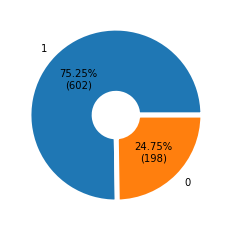

In [123]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:
# 방법
#    1) 오버 샘플링 (https://wyatt37.tistory.com/10)
#        1. 랜덤 추출 오버 샘플링(Random Over Sampling, ROS)
#        2. SMOTE
#        3. ADASYN
#        4. BorderlineSMOTE
#    2) 언더 샘플링
#    3) 혼합 샘플링

In [ ]:
# 1) 오버 샘플링

In [ ]:
# 1. 랜덤 추출 오버 샘플링(Random Over Sampling, ROS)
# 존재하는 데이터를 무작위로 선정해서 복사 = 오버 피팅 가능성 증가






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [124]:
ros = RandomOverSampler()

X_train_over,y_train_over = ros.fit_resample(
    comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"],
    comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"])

comp_trainDf = pd.concat([X_train_over, y_train_over], axis=1)
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.695920,0.173913,1.0,1.0,0.333333,1.0,0.446786,0.193388,0.05,1
1,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.695920,0.000000,1.0,0.0,0.000000,0.0,0.684114,0.807625,0.85,1
2,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.605126,0.304348,1.0,1.0,0.000000,0.0,0.052430,0.752727,1.00,1
3,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.605126,0.173913,1.0,1.0,0.333333,0.0,0.417697,0.127273,0.70,1
4,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.0,1.0,0.666667,0.0,0.054868,0.098182,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,0.348643,1.000000,0.093056,0.333333,0.319719,0.090909,0.096925,1.0,1.000000,0.000000,...,0.695920,0.956522,1.0,0.0,0.000000,0.0,0.605992,0.098182,0.65,0
1200,0.839248,0.000000,0.000000,1.000000,0.527647,0.090909,0.075732,0.0,0.077825,0.333661,...,0.695920,0.826087,1.0,0.0,0.666667,1.0,0.589357,0.098182,0.90,0
1201,0.392484,1.000000,0.000000,0.333333,0.561812,0.090909,0.089962,0.0,0.969576,0.733168,...,0.605126,0.347826,0.0,0.5,0.000000,0.0,0.661122,0.293023,0.00,0
1202,0.605428,0.000000,0.093056,0.333333,0.543884,0.090909,0.112366,1.0,0.733826,0.661270,...,0.605126,1.000000,0.0,0.0,0.000000,1.0,0.457673,0.175758,0.30,0


([<matplotlib.patches.Wedge at 0x7fb5ace430f0>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%\n(602)'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%\n(602)')])

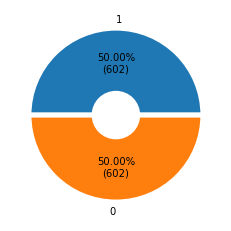

In [125]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 2. SMOTE
# 변수들간의 거리를 파악해서 군집상 가까운 데이터를 증량






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [127]:
sm = SMOTE()

X_train_over,y_train_over = sm.fit_resample(
    comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"],
    comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"])

comp_trainDf = pd.concat([X_train_over, y_train_over], axis=1)
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.000000,0.077825,0.356676,...,0.695920,0.173913,1.000000,1.000000,0.333333,1.000000,0.446786,0.193388,0.050000,1
1,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.000000,0.000000,0.785611,...,0.695920,0.000000,1.000000,0.000000,0.000000,0.000000,0.684114,0.807625,0.850000,1
2,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.000000,0.969576,0.826036,...,0.605126,0.304348,1.000000,1.000000,0.000000,0.000000,0.052430,0.752727,1.000000,1
3,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.000000,1.000000,1.000000,...,0.605126,0.173913,1.000000,1.000000,0.333333,0.000000,0.417697,0.127273,0.700000,1
4,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.000000,0.000000,1.000000,...,0.605126,0.304348,1.000000,1.000000,0.666667,0.000000,0.054868,0.098182,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,0.894561,0.100391,0.015176,1.000000,0.697606,0.243076,0.347142,0.836919,0.614603,0.421953,...,0.503544,0.236792,0.000000,1.000000,0.333333,1.000000,0.666399,0.165613,0.083692,0
1200,0.375402,0.000000,0.000000,1.000000,0.438877,0.090909,0.717512,0.000000,0.000648,0.078226,...,0.674634,0.682754,1.000000,0.117223,0.744816,1.000000,0.407185,0.697200,0.379666,0
1201,0.325678,1.000000,0.026535,0.000000,0.628374,0.090909,0.102032,0.000000,0.991325,0.736117,...,0.944900,0.751355,0.285147,0.357427,1.000000,0.714853,0.601224,0.322787,0.507427,0
1202,0.488151,0.045147,0.035024,0.000000,0.478019,0.090909,0.947540,0.000000,0.001723,0.456964,...,0.765046,0.760631,0.623626,0.688187,0.541209,0.000000,0.481067,0.296778,0.731731,0


([<matplotlib.patches.Wedge at 0x7fb5ad1f2b38>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%\n(602)'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%\n(602)')])

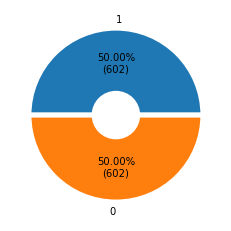

In [128]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 3. ADASYN
# SMOTE 를 개선한 방식
# 뚜렷한 증량 방식을 가진 SMOTE에서 나오는 법칙이 훈련할 모델에 영향을 줄 수 있으니 
# 이에 무작위 극소값을 더해줌으로 보다 사실적인 데이터를 반환(= 표본의 분산이 약간 늘어남)







#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [130]:
ada = ADASYN()
X_train_over,y_train_over = ada.fit_resample(
    comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"],
    comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"])

comp_trainDf = pd.concat([X_train_over, y_train_over], axis=1)
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.695920,0.173913,1.000000,1.000000,0.333333,1.000000,0.446786,0.193388,0.050000,1
1,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.695920,0.000000,1.000000,0.000000,0.000000,0.000000,0.684114,0.807625,0.850000,1
2,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.605126,0.304348,1.000000,1.000000,0.000000,0.000000,0.052430,0.752727,1.000000,1
3,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.605126,0.173913,1.000000,1.000000,0.333333,0.000000,0.417697,0.127273,0.700000,1
4,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.000000,1.000000,0.666667,0.000000,0.054868,0.098182,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.457883,0.092982,0.093056,0.258383,0.457370,0.938677,0.108272,0.0,0.019640,0.609974,...,0.927335,0.579367,1.000000,0.112425,0.333333,0.224850,0.481418,0.635588,0.257395,0
1188,0.257433,0.000000,0.093056,0.066865,0.575334,0.599621,0.214750,0.0,0.062214,0.417796,...,0.784531,0.425932,1.000000,0.500000,0.400198,1.000000,0.710552,0.794211,0.749851,0
1189,0.537082,0.119953,0.000000,0.000000,0.586717,0.090909,0.931341,0.0,0.002762,0.611696,...,0.405885,0.262345,1.000000,0.000000,0.666667,0.997738,0.450530,0.437510,0.350566,0
1190,0.530718,0.026039,0.020200,0.000000,0.542856,0.090909,0.949861,0.0,0.002163,0.404778,...,0.782703,0.788334,0.782921,0.608539,0.594307,0.000000,0.449602,0.275056,0.675978,0


([<matplotlib.patches.Wedge at 0x7fb5ad31e048>,
 [Text(-0.01739398426538406, 1.099862468362011, '1'),
  Text(0.017393984265383928, -1.099862468362011, '0')],
 [Text(-0.009487627781118578, 0.5999249827429151, '50.50%\n(602)'),
  Text(0.009487627781118505, -0.5999249827429151, '49.50%\n(590)')])

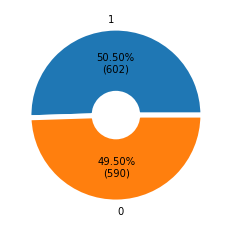

In [131]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 4. BorderlineSMOTE
# SMOTE 를 개선한 방식
# 모든 오버 샘플링은 '이상치'에 영향을 받을 수 있는데, 이를 해결한 방식입니다.







#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [139]:
bs = BorderlineSMOTE()
X_train_over,y_train_over = bs.fit_resample(
    comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"],
    comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"])

comp_trainDf = pd.concat([X_train_over, y_train_over], axis=1)
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.695920,0.173913,1.0,1.000000,0.333333,1.000000,0.446786,0.193388,0.050000,1
1,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.695920,0.000000,1.0,0.000000,0.000000,0.000000,0.684114,0.807625,0.850000,1
2,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.605126,0.304348,1.0,1.000000,0.000000,0.000000,0.052430,0.752727,1.000000,1
3,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.605126,0.173913,1.0,1.000000,0.333333,0.000000,0.417697,0.127273,0.700000,1
4,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.0,1.000000,0.666667,0.000000,0.054868,0.098182,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,0.285880,0.521671,0.000000,0.000000,0.416284,0.090909,0.218518,1.0,0.019348,0.406924,...,0.646571,0.517032,0.0,0.456473,0.152158,0.456473,0.513430,0.488510,0.231529,0
1200,0.614270,0.508699,0.538638,0.000000,0.666263,0.090909,0.204428,0.0,0.985053,0.384913,...,1.000000,0.546126,0.0,1.000000,0.333333,0.000000,0.577071,0.507658,0.507830,0
1201,0.341165,0.065107,0.093056,0.333333,0.495392,0.628588,0.939125,1.0,0.855530,0.692324,...,0.678034,0.775171,1.0,0.771383,1.000000,0.000000,0.529948,0.564976,0.872862,0
1202,0.158076,0.000000,0.009067,0.300854,0.401811,0.090909,0.294136,1.0,0.045839,0.497377,...,0.000000,0.608696,1.0,0.548719,0.032480,1.000000,0.442189,0.561456,0.519488,0


([<matplotlib.patches.Wedge at 0x7fb5aceae518>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%\n(602)'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%\n(602)')])

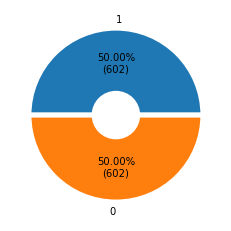

In [140]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 2) 언더 샘플링
# 많은 데이터를 제거하여 데이터 균형 맞추기






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!








In [136]:
rusmp = RandomUnderSampler()

X_train_over,y_train_over = rusmp.fit_resample(
    comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"],
    comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"])

comp_trainDf = pd.concat([X_train_over, y_train_over], axis=1)
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.0,1.0,0.666667,0.0,0.054868,0.098182,0.50,0
1,0.845511,1.000000,0.000000,0.000000,0.498402,0.090909,0.170698,0.0,0.002762,0.000000,...,0.000000,0.478261,1.0,0.0,0.000000,0.0,0.552865,0.098182,0.10,0
2,0.505219,1.000000,1.000000,1.000000,0.596905,0.636364,0.985146,1.0,0.042386,1.000000,...,0.695920,0.652174,1.0,0.5,0.666667,1.0,0.581780,0.397403,0.20,0
3,0.941545,0.119953,0.000000,1.000000,0.734281,0.272727,0.237365,1.0,0.733826,0.384913,...,0.406805,0.130435,0.0,1.0,0.333333,1.0,0.679324,0.163636,0.10,0
4,0.507307,0.119953,0.093056,0.333333,0.431095,0.090909,0.210030,1.0,0.042386,0.333661,...,0.605126,0.043478,1.0,0.5,0.000000,1.0,0.437206,0.736364,0.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.056367,0.119953,0.093056,1.000000,0.424609,0.090909,0.213572,1.0,0.042386,0.998913,...,1.000000,1.000000,1.0,0.5,1.000000,0.0,0.535273,0.397403,0.65,1
392,0.229645,0.000000,1.000000,0.333333,0.762783,0.090909,0.187663,1.0,0.733826,1.000000,...,0.695920,0.130435,1.0,0.0,1.000000,0.0,0.499913,0.437838,0.75,1
393,0.323591,0.000000,0.000000,0.333333,0.301092,0.090909,0.154214,1.0,0.733826,0.733168,...,1.000000,0.000000,1.0,0.0,1.000000,0.0,0.420310,0.381818,0.10,1
394,0.993737,0.119953,0.000000,0.333333,0.699683,0.090909,0.151385,1.0,1.000000,0.826036,...,0.605126,0.434783,1.0,0.5,0.666667,1.0,0.429281,0.736364,0.70,1


([<matplotlib.patches.Wedge at 0x7fb5acfea6a0>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%\n(198)'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%\n(198)')])

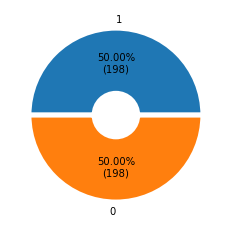

In [137]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(comp_trainDf['fraud_reported'].value_counts(),autopct=make_autopct(comp_trainDf['fraud_reported'].value_counts()), 
        labels=comp_trainDf['fraud_reported'].value_counts().index, 
        wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 5})

In [ ]:






#!!!!!!!!!!!!!!!!!!!!!!!!!!!! 샘플링 완료 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!







In [ ]:
# 3) 혼합 샘플링
# 많은 데이터는 제거, 적은 데이터는 증량하여 오버피팅을 줄이는 동시에 실제 데이터 제거 수 감소




# <TODO>





In [ ]:
#########################################################################################################################################







In [ ]:
# <5> 모델 적합
# 위까지의 데이터 전처리 과정에서 데이터가 준비되었습니다.
# 결과 정리와 전달을 제외하곤 데이터 분석 프로세스 마지막 단계로 분석 모델을 만들고 평가합시다.

In [141]:
comp_trainDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
0,0.507307,1.000000,0.000000,0.000000,0.232788,0.090909,0.891259,0.0,0.077825,0.356676,...,0.695920,0.173913,1.0,1.000000,0.333333,1.000000,0.446786,0.193388,0.050000,1
1,0.286013,0.119953,0.000000,0.333333,0.557543,0.090909,0.060841,0.0,0.000000,0.785611,...,0.695920,0.000000,1.0,0.000000,0.000000,0.000000,0.684114,0.807625,0.850000,1
2,0.131524,0.000000,0.000000,1.000000,0.735668,0.090909,0.207049,1.0,0.969576,0.826036,...,0.605126,0.304348,1.0,1.000000,0.000000,0.000000,0.052430,0.752727,1.000000,1
3,0.601253,1.000000,0.093056,0.333333,0.379976,0.090909,0.977743,0.0,1.000000,1.000000,...,0.605126,0.173913,1.0,1.000000,0.333333,0.000000,0.417697,0.127273,0.700000,1
4,0.532359,0.000000,1.000000,1.000000,0.236412,0.636364,0.027052,1.0,0.000000,1.000000,...,0.605126,0.304348,1.0,1.000000,0.666667,0.000000,0.054868,0.098182,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,0.285880,0.521671,0.000000,0.000000,0.416284,0.090909,0.218518,1.0,0.019348,0.406924,...,0.646571,0.517032,0.0,0.456473,0.152158,0.456473,0.513430,0.488510,0.231529,0
1200,0.614270,0.508699,0.538638,0.000000,0.666263,0.090909,0.204428,0.0,0.985053,0.384913,...,1.000000,0.546126,0.0,1.000000,0.333333,0.000000,0.577071,0.507658,0.507830,0
1201,0.341165,0.065107,0.093056,0.333333,0.495392,0.628588,0.939125,1.0,0.855530,0.692324,...,0.678034,0.775171,1.0,0.771383,1.000000,0.000000,0.529948,0.564976,0.872862,0
1202,0.158076,0.000000,0.009067,0.300854,0.401811,0.090909,0.294136,1.0,0.045839,0.497377,...,0.000000,0.608696,1.0,0.548719,0.032480,1.000000,0.442189,0.561456,0.519488,0


In [142]:
comp_testDf

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,incident_city,incident_hour_of_the_day,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_model,auto_year,fraud_reported
424,0.313152,0.119953,1.000000,0.333333,0.570645,0.090909,0.138836,0.0,1.000000,0.661270,...,0.000000,0.260870,1.0,0.0,1.000000,1.0,0.563491,0.397403,0.25,0
116,0.223382,1.000000,1.000000,1.000000,0.582861,0.090909,0.212194,1.0,0.000000,0.661270,...,0.605126,0.695652,1.0,0.0,1.000000,0.0,0.445567,0.736364,0.35,1
335,0.252610,1.000000,1.000000,0.333333,0.389435,0.636364,0.056236,1.0,0.077825,0.612036,...,0.605126,0.695652,1.0,0.0,0.333333,1.0,0.567410,1.000000,0.35,1
559,0.405010,0.119953,0.093056,1.000000,0.494295,0.090909,0.912872,1.0,0.000000,0.356676,...,0.000000,0.652174,1.0,0.5,0.000000,0.0,0.466643,0.771429,0.80,1
97,0.060543,1.000000,0.000000,1.000000,0.569611,0.090909,0.182623,0.0,1.000000,0.333661,...,0.605126,0.173913,0.0,0.5,0.666667,1.0,0.564275,0.807625,0.90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0.743215,0.119953,0.000000,1.000000,0.447660,0.090909,0.005239,0.0,0.969576,0.785611,...,0.406805,0.217391,0.0,0.0,1.000000,0.0,0.534663,0.293023,0.70,1
283,0.910230,0.000000,0.000000,1.000000,0.603174,0.545455,0.238926,0.0,0.000000,0.433133,...,0.962309,0.434783,1.0,0.0,0.666667,0.0,0.520815,0.348617,0.10,0
599,0.498956,0.000000,0.000000,0.333333,0.522468,0.545455,0.943854,1.0,1.000000,0.826036,...,1.000000,0.521739,1.0,0.5,1.000000,0.0,0.538408,0.621818,0.40,1
615,0.319415,1.000000,0.000000,0.000000,0.345706,0.090909,0.100368,0.0,0.969576,0.433133,...,0.695920,0.000000,1.0,0.5,0.000000,0.0,0.676450,0.807625,0.25,1


In [143]:
train_x = comp_trainDf.loc[:, comp_trainDf.columns!="fraud_reported"]
train_y = comp_trainDf.loc[:, comp_trainDf.columns=="fraud_reported"].values.ravel()

test_x = comp_testDf.loc[:, comp_testDf.columns!="fraud_reported"]
test_y = comp_testDf.loc[:, comp_testDf.columns=="fraud_reported"].values.ravel()

In [ ]:
# (모델 종류)

# Naive Bayes classifier
# Logistic Regression
# Decision Tree
# SVM
# DNN
# Random Forest
# XG Boost


In [ ]:

# >>>>>>>>>


In [144]:
# 1) Naive Bayes classifier
# GaussianNB : 연속적인 어떤 데이터에도 적용가능
# BernoulliNB : 이진(binary) 데이터에 적용가능
# MultinomialNB : 카운트 데이터(ex 문장에 나타난 단어의 횟수)에 적용가능

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

model_gs_nb = GridSearchCV(GaussianNB(), 
                 param_grid=params_nb, cv=3, refit=True) 

model_gs_nb.fit(train_x, train_y)

print('best parameters : ', model_gs_nb.best_params_)
print('best score : ', model_gs_nb.best_score_)

best parameters :  {'var_smoothing': 0.0015199110829529332}
best score :  0.8447124311939884


In [151]:
# 모델 생성
# 그리드 서치로 얻어낸 파라미터 적용
model_nb = GaussianNB(var_smoothing= 0.0015199110829529332).fit(train_x, train_y)

# 모델 예측 테스트
pred_nb = model_nb.predict(test_x) 
print(classification_report(test_y, pred_nb))

              precision    recall  f1-score   support

           0       0.49      0.86      0.62        49
           1       0.94      0.71      0.81       151

    accuracy                           0.74       200
   macro avg       0.71      0.78      0.71       200
weighted avg       0.83      0.74      0.76       200



In [ ]:
# 위 결과표의 해석은, 
# 0행 : 실제 데이터가 0일 때만을 놓고 봤을 때의 결과 (실제 데이터 0에 대한 예측력)
# 1행 : 실제 데이터가 1일 때만을 놓고 봤을 때의 결과 (실제 데이터 1에 대한 예측력)
# accuracy : 전체 데이터 분류 정확도
# macro avg : 단순히 계산한 전체 평가값
# weighted avg : 각 클래스에 속하는 표본 갯수를 반영한 전체 평가값

# 위와 같으며, 단순하게 테스트 정확도가 0.74로 나쁘지는 않지만,
# 실제로 fraud라고 판단해낸 성능은 굉장히 나쁜 편입니다.

In [ ]:

# >>>>>>>>>


In [152]:
# 2) Logistic Regression

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l2']}

model_gs_lr = GridSearchCV(LogisticRegression(), 
                 param_grid=params_lr, cv=3, refit=True) 

model_gs_lr.fit(train_x, train_y)

print('best parameters : ', model_gs_lr.best_params_)
print('best score : ', model_gs_lr.best_score_)

best parameters :  {'C': 0.1, 'penalty': 'l2'}
best score :  0.8795631154286753


In [153]:
# 모델 생성 및 학습
model_lr = LogisticRegression(C = 0.1, penalty = 'l2').fit(train_x, train_y)

pred_lr= model_lr.predict(test_x)
print(classification_report(test_y, pred_lr))

              precision    recall  f1-score   support

           0       0.56      0.84      0.67        49
           1       0.94      0.79      0.86       151

    accuracy                           0.80       200
   macro avg       0.75      0.81      0.76       200
weighted avg       0.85      0.80      0.81       200



In [ ]:

# >>>>>>>>>


In [154]:
# 3) Decision Tree

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_dt = { 'criterion':['gini','entropy'],
             'max_depth': np.arange(3, 30)}

model_gs_dt = GridSearchCV(tree.DecisionTreeClassifier(), 
                 param_grid=params_dt, cv=3, refit=True)

model_gs_dt.fit(train_x, train_y)

print('best parameters : ', model_gs_dt.best_params_)
print('best score : ', model_gs_dt.best_score_)

best parameters :  {'criterion': 'gini', 'max_depth': 4}
best score :  0.885412918780991


In [155]:
# 모델 생성 및 학습
model_dt = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 4)
model_dt.fit(train_x, train_y)

pred_dt= model_dt.predict(test_x)  
print(classification_report(test_y, pred_dt))

              precision    recall  f1-score   support

           0       0.57      0.82      0.67        49
           1       0.93      0.80      0.86       151

    accuracy                           0.81       200
   macro avg       0.75      0.81      0.77       200
weighted avg       0.84      0.81      0.81       200



[Text(567.9642857142857, 733.86, 'incident_severity <= 0.882\ngini = 0.5\nsamples = 1204\nvalue = [602, 602]\nclass = 1'),
 Text(318.85714285714283, 570.78, 'insured_hobbies <= 0.997\ngini = 0.268\nsamples = 490\nvalue = [412, 78]\nclass = 1'),
 Text(159.42857142857142, 407.70000000000005, 'insured_occupation <= 1.0\ngini = 0.241\nsamples = 472\nvalue = [406, 66]\nclass = 1'),
 Text(79.71428571428571, 244.62, 'auto_model <= 0.803\ngini = 0.206\nsamples = 445\nvalue = [393, 52]\nclass = 1'),
 Text(39.857142857142854, 81.54000000000008, 'gini = 0.184\nsamples = 429\nvalue = [385, 44]\nclass = 1'),
 Text(119.57142857142856, 81.54000000000008, 'gini = 0.5\nsamples = 16\nvalue = [8, 8]\nclass = 1'),
 Text(239.1428571428571, 244.62, 'witnesses <= 0.57\ngini = 0.499\nsamples = 27\nvalue = [13, 14]\nclass = 1'),
 Text(199.28571428571428, 81.54000000000008, 'gini = 0.391\nsamples = 15\nvalue = [11, 4]\nclass = 1'),
 Text(279.0, 81.54000000000008, 'gini = 0.278\nsamples = 12\nvalue = [2, 10]\ncl

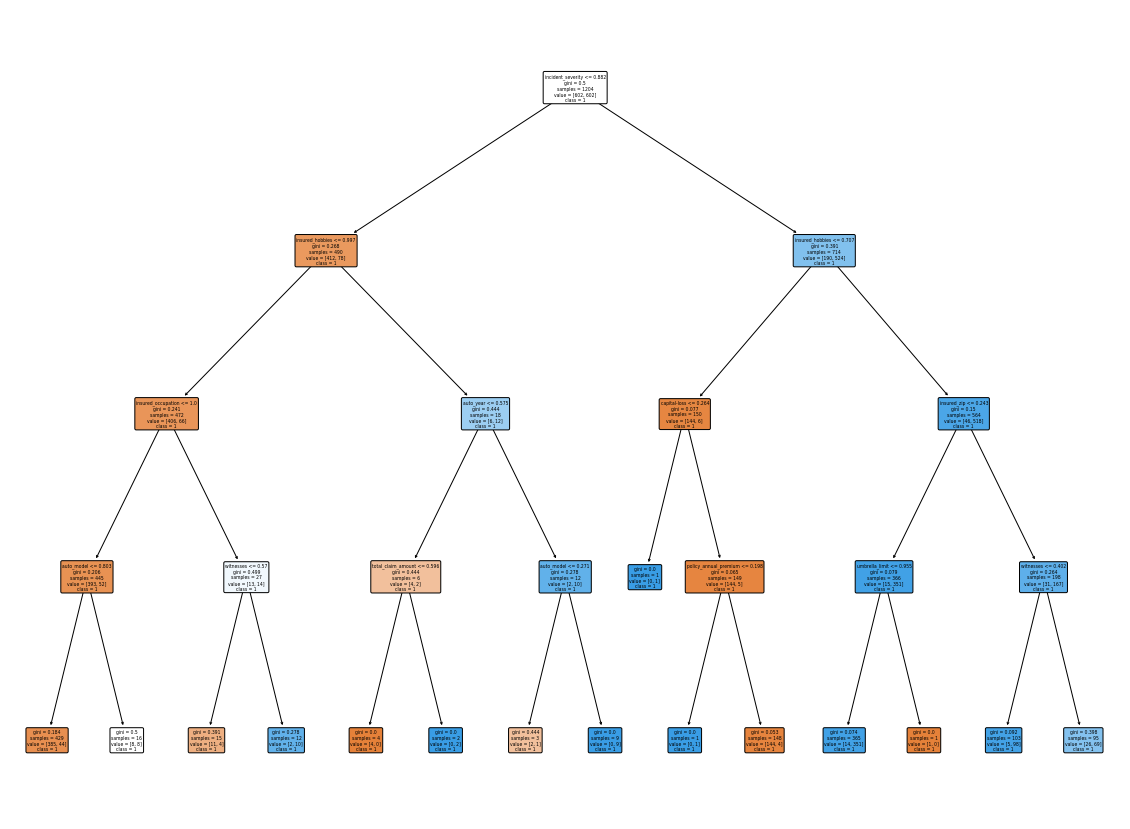

In [156]:
# 나무 시각화
plt.figure( figsize=(20,15) )
tree.plot_tree(model_dt, 
               class_names=train_y.astype(str),
               feature_names=train_x.columns,
               impurity=True, filled=True,
               rounded=True)

In [157]:
# feature별 importance 확인
impRankDf = pd.concat([pd.DataFrame(test_x.columns, columns = ["pc"]),
           pd.DataFrame(model_dt.feature_importances_, columns = ["imp"])], axis=1).sort_values(by=['imp'], axis=0, ascending=False)
impRankDf

,pc,imp
10,insured_hobbies,0.455594
16,incident_severity,0.454327
23,witnesses,0.021992
9,insured_occupation,0.019441
26,auto_model,0.016267
6,insured_zip,0.008126
25,total_claim_amount,0.006312
27,auto_year,0.004734
4,policy_annual_premium,0.004451
13,capital-loss,0.004392


<AxesSubplot:xlabel='imp', ylabel='pc'>

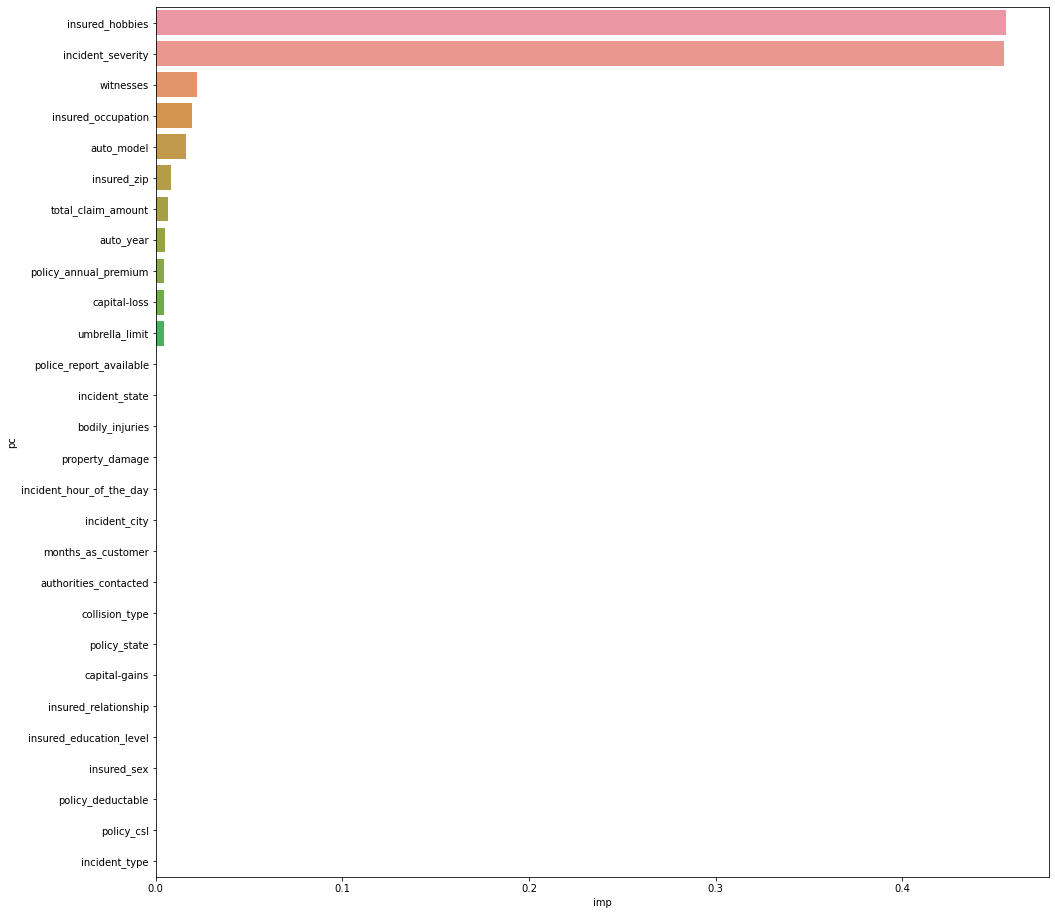

In [158]:
# feature importance를 column 별로 시각화 하기 
plt.figure(figsize=(16, 16))
sb.barplot(x=impRankDf['imp'] , y=impRankDf['pc'])

In [ ]:

# >>>>>>>>>


In [159]:
# 4) SVM

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_svm = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

model_gs_svm = GridSearchCV(svm.SVC(), 
                 param_grid=params_svm, cv=3, refit=True) 

model_gs_svm.fit(train_x, train_y)

print('best parameters : ', model_gs_svm.best_params_)
print('best score : ', model_gs_svm.best_score_)

best parameters :  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
best score :  0.9452240046649546


In [160]:
# 모델 생성 및 학습
model_svm = svm.SVC(C = 1, gamma = 1, kernel = 'rbf')
model_svm.fit(train_x, train_y)

pred_svm= model_svm.predict(test_x) 
print(classification_report(test_y, pred_svm))

              precision    recall  f1-score   support

           0       0.55      0.22      0.32        49
           1       0.79      0.94      0.86       151

    accuracy                           0.77       200
   macro avg       0.67      0.58      0.59       200
weighted avg       0.73      0.77      0.73       200



In [ ]:

# >>>>>>>>>


In [162]:
# 5) DNN (tensor flow)
# 그리드 서치
# 최적의 파라미터를 찾습니다.

def binary_dnn_model_builder(nodes1=16, nodes2=16, activation1='relu', activation2='relu'):
  model = Sequential()
  model.add(Dense(nodes1, activation=activation1))
  model.add(Dense(nodes2, activation=activation2))
  model.add(Dense(1, activation='sigmoid')) # 이진분류니까 노드수 1, 활성함수로는 시그모이드
    
  model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

  return model


# GridSearch 파라미터 설정
params_dnn = dict(batch_size=[50, 100, 300], 
                  epochs=[10, 20, 30], 
                  nodes1=[64, 128, 256], 
                  nodes2=[64, 128, 256],
                  activation1 = ['relu', 'sigmoid'],
                  activation2 = ['relu', 'sigmoid'])


# GridSearch CV를 만들기
model_gs_dnn = GridSearchCV(KerasClassifier(build_fn=binary_dnn_model_builder), 
                            param_grid=params_dnn, 
                            cv=3, 
                            n_jobs=-1)

model_gs_dnn.fit(train_x, train_y)

print('best parameters : ', model_gs_dnn.best_params_)
print('best score : ', model_gs_dnn.best_score_)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 0s 1ms/step - loss: 0.6024 - accuracy: 0.7135
Epoch 2/30
25/25 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8214
Epoch 3/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3831 - accuracy: 0.8580
Epoch 4/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3319 - accuracy: 0.8846
Epoch 5/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3131 - accuracy: 0.8870
Epoch 6/30
25/25 [

In [163]:
# 모델 생성 및 학습
model_dnn = KerasClassifier(build_fn=binary_dnn_model_builder, 
                            activation1 = 'relu', 
                            activation2 = 'relu', 
                            batch_size = 50, 
                            epochs = 30, 
                            nodes1 = 256, 
                            nodes2 = 256)
model_dnn.fit(train_x, train_y)

# 모델 예측 테스트
pred_dnn= model_dnn.predict(test_x)
print(classification_report(test_y, pred_dnn))

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 0s 1ms/step - loss: 0.6139 - accuracy: 0.6819
Epoch 2/30
25/25 [==============================] - 0s 1ms/step - loss: 0.4881 - accuracy: 0.7849
Epoch 3/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3955 - accuracy: 0.8472
Epoch 4/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3493 - accuracy: 0.8704
Epoch 5/30
25/25 [==============================] - 0s 1ms/step - loss: 0.3148 - accuracy: 0.8870
Epoch 6/30
25/25 [

In [165]:

# >>>>>>>>>


In [ ]:
# 6) Random Forest

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20],
             'max_features' : [4, 8, 12, 16, 20]
            }
# max_depth 는 위에서 알아낸 의사결정나무의 최대 효율 depth를 참고
# max_features 로 나무별 사용할 특징값 설정
# n_estimators 로 나무 개수를 설정

model_gs_rf = GridSearchCV(RandomForestClassifier(), 
                 param_grid=params_rf, cv=3, refit=True) 

model_gs_rf.fit(train_x, train_y)

print('best parameters : ', model_gs_rf.best_params_)
print('best score : ', model_gs_rf.best_score_)

In [ ]:
# 모델 생성 및 학습
model_rf = RandomForestClassifier(max_depth = 6, 
                                  max_features = 20, 
                                  min_samples_leaf = 8, 
                                  min_samples_split = 8, 
                                  n_estimators = 10)
model_rf.fit(train_x, train_y)

# 모델 예측 테스트
pred_rf= model_rf.predict(test_x)
print(classification_report(test_y, pred_rf))

In [ ]:
# feature별 importance 확인
impRankDf = pd.concat([pd.DataFrame(test_x.columns, columns = ["pc"]),
           pd.DataFrame(model_rf.feature_importances_, columns = ["imp"])], axis=1).sort_values(by=['imp'], axis=0, ascending=False)
impRankDf

In [ ]:
# feature importance를 column 별로 시각화 하기 
plt.figure(figsize=(16, 16))
sb.barplot(x=impRankDf['imp'] , y=impRankDf['pc'])

In [ ]:

# >>>>>>>>>


In [169]:
# 7) XG Boost

# 그리드 서치
# 최적의 파라미터를 찾습니다.
params_xgb = {'max_depth': [3,5,7], 
              'subsample': [0.6, 0.8, 1.0]}

model_gs_xgb = GridSearchCV(xgboost.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss'), 
                 param_grid=params_xgb, cv=3,
                       n_jobs=8, refit=True) 

model_gs_xgb.fit(train_x, train_y)

print('best parameters : ', model_gs_xgb.best_params_)
print('best score : ', model_gs_xgb.best_score_)

best parameters :  {'max_depth': 7, 'subsample': 1.0}
best score :  0.8829729159687846


In [170]:
# 모델 생성 및 학습
model_xgb = xgboost.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss', max_depth = 7, subsample=1.0)
model_xgb.fit(train_x, train_y)

# 모델 예측 테스트
pred_xgb= model_xgb.predict(test_x)
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63        49
           1       0.89      0.83      0.86       151

    accuracy                           0.80       200
   macro avg       0.73      0.76      0.75       200
weighted avg       0.82      0.80      0.81       200



In [171]:
# feature별 importance 확인
# grid search 한 파라미터를 적용한 모델을 파악
impRankDf = pd.concat([pd.DataFrame(test_x.columns, columns = ["pc"]),
           pd.DataFrame(model_xgb.feature_importances_, columns = ["imp"])], axis=1).sort_values(by=['imp'], axis=0, ascending=False)
impRankDf

,pc,imp
16,incident_severity,0.284369
10,insured_hobbies,0.210182
5,umbrella_limit,0.035674
15,collision_type,0.032587
11,insured_relationship,0.028427
26,auto_model,0.026397
6,insured_zip,0.025771
23,witnesses,0.022616
18,incident_state,0.022173
14,incident_type,0.022153


<AxesSubplot:xlabel='imp', ylabel='pc'>

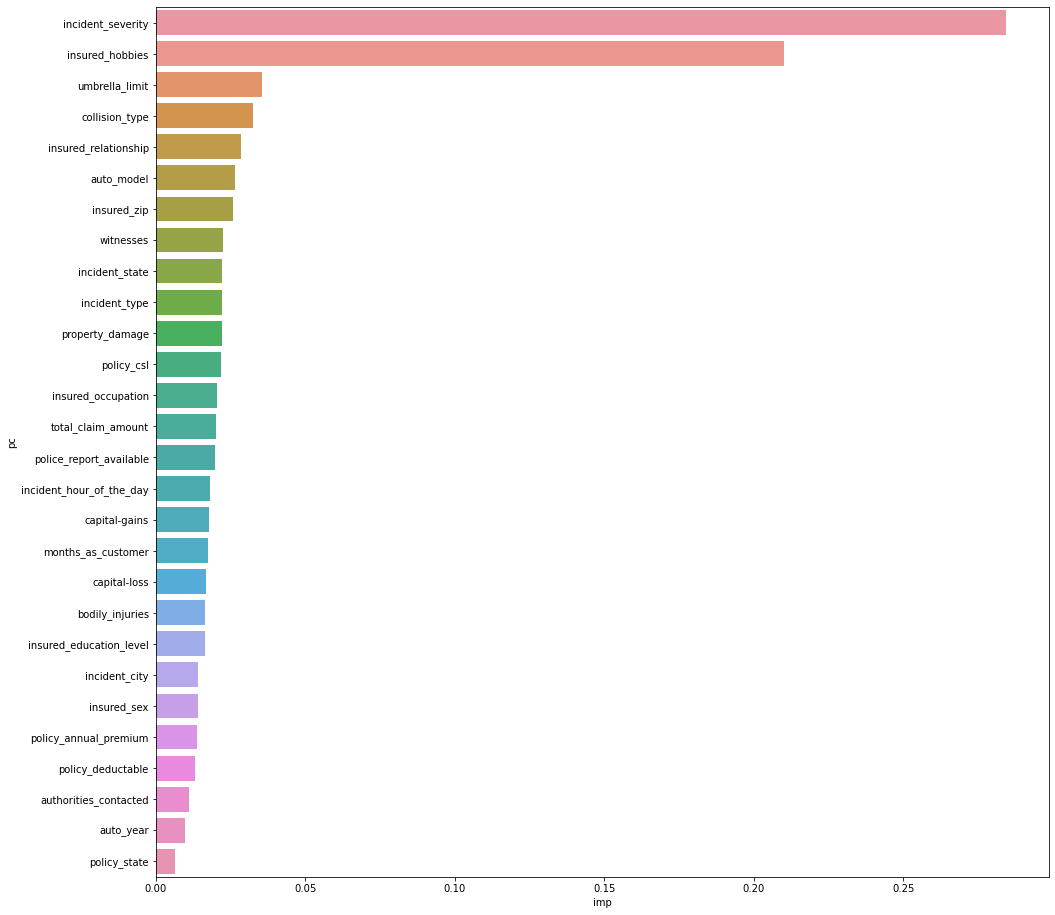

In [172]:
# feature importance를 column 별로 시각화 하기 
plt.figure(figsize=(16, 16))
sb.barplot(x=impRankDf['imp'] , y=impRankDf['pc'])

In [ ]:

# >>>>>>>>>
